In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pdPath
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import metrics
import copy
import time
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE

In [2]:
# CED
# train_val, test = nonlinear_benchmarks.CED()
# print(test[0].state_initialization_window_length) # = 4
# (train_val_u_1, train_val_y_1), (train_val_u_2, train_val_y_2) = train_val
# (test_u_1, test_y_1), (test_u_2, test_y_2) = test

# WienerHammerstein
# train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
# seq_len_n_in_ext = test.state_initialization_window_length
# train_val_u, train_val_y = train_val
# test_u, test_y = test
# ctx_length = 100000
# n_query = test_y.shape[0]

# Silverbox
train, test = nonlinear_benchmarks.Silverbox()
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
(train_val_u, train_val_y) = train
(test_u_1, test_y_1) = test_multisine
(test_u_2, test_y_2) = test_arrow_full
(test_u_3, test_y_3) = test_arrow_no_extrapolation
ctx_length = train_val_u.shape[0]
n_query1 = test_y_1.shape[0]
n_query2 = test_y_2.shape[0]
n_query3 = test_y_3.shape[0]
n = test_multisine.state_initialization_window_length

In [3]:
n_query3

32000

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(452)
np.random.seed(55)
system_seed = 66 # Controls the system generation
data_seed = 0 # Controls the input generation

In [5]:
# Overall settings
out_dir_name = "active_430_400skip_decoder"

# System settings
nu = 1
ny = 1
fixed_system = False # Are we testing on a fixed system?

# Compute settings
no_cuda = False
threads = 5
cuda_device = 'cuda:0'
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = torch.cuda.is_available()
device_name = cuda_device if use_cuda else "cpu"
print(device_name)
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu'
torch.set_float32_matmul_precision("high")


cuda:0


In [6]:

# Create out dir
out_dir = Path(out_dir_name)
exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k.pt", map_location=device)
exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k.pt", map_location=device)
# exp_data = torch.load(out_dir / "resume_top32_over160_fixed_err0.01.pt", map_location=device) # for focusing more on the tails

cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

cfg2 = exp_data2["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg2.seed
except AttributeError:
    cfg2.seed = None

In [7]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
# model = TSTransformer_paper(conf).to(device)/
model.load_state_dict(exp_data["model"]);
# cfg.seed +=1

1


In [8]:
model_args2 = exp_data2["model_args"]
conf2 = Config(**model_args2)
model2 = TSTransformer(conf2).to(device)
# model = TSTransformer_paper(conf).to(device)/
model2.load_state_dict(exp_data2["model"]);
# cfg.seed +=1

1


In [9]:
# model_args3 = exp_data3["model_args"]
# conf3 = Config(**model_args3)
# model3 = TSTransformer(conf3).to(device)
# # model = TSTransformer_paper(conf).to(device)/
# model3.load_state_dict(exp_data3["model"]);

In [10]:
b = 216
b2 = 404
b3 = 319

b_train = 1


train_val_y,train_val_u,test_u_1, test_y_1 = torch.tensor(train_val_y).view(1,ctx_length,1),torch.tensor(train_val_u).view(1,ctx_length,1),torch.tensor(test_u_1).view(1,n_query1,1),torch.tensor(test_y_1).view(1,n_query1,1)
test_u_1 = test_u_1[:,:b*100+30,:].to(device)
test_y_1 = test_y_1[:,:b*100+30,:].to(device)
train_val_u = train_val_u[:,:b_train*400,:].to(device)
train_val_y = train_val_y[:,:b_train*400,:].to(device)

mean_train_u_1, std_train_u_1, mean_train_y_1, std_train_y_1 = train_val_u.mean(),train_val_u.std(),train_val_y.mean(),train_val_y.std()
train_val_y_norm, train_val_u_norm, test_u_1_norm, test_y_1_norm = (train_val_y-mean_train_y_1)/(std_train_y_1+1e-6),(train_val_u-mean_train_u_1)/(std_train_u_1+1e-6),(test_u_1-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_1-mean_train_y_1)/(std_train_y_1+1e-6)
train_val_u_norm = torch.stack([train_val_u_norm[0, i * 400 : (i + 1) * 400, :] for i in range(b_train)])
train_val_y_norm = torch.stack([train_val_y_norm[0, i * 400 : (i + 1) * 400, :] for i in range(b_train)])
test_u_1_norm = torch.stack([test_u_1_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b)])
test_y_1_norm = torch.stack([test_y_1_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b)])


test_u_2, test_y_2 = torch.tensor(test_u_2).view(1,n_query2,1),torch.tensor(test_y_2).view(1,n_query2,1)
test_u_2 = test_u_2[:,:b2*100+30,:].to(device)
test_y_2 = test_y_2[:,:b2*100+30,:].to(device)

test_u_2_norm, test_y_2_norm = (test_u_2-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_2-mean_train_y_1)/(std_train_y_1+1e-6)
test_u_2_norm = torch.stack([test_u_2_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_y_2_norm = torch.stack([test_y_2_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b2)])

test_u_3, test_y_3 = torch.tensor(test_u_3).view(1,n_query3,1),torch.tensor(test_y_3).view(1,n_query3,1)
test_u_3 = test_u_3[:,:b3*100+30,:].to(device)
test_y_3 = test_y_3[:,:b3*100+30,:].to(device)

test_u_3_norm, test_y_3_norm = (test_u_3-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_3-mean_train_y_1)/(std_train_y_1+1e-6)
test_u_3_norm = torch.stack([test_u_3_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_y_3_norm = torch.stack([test_y_3_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b3)])


train_val_y_1_norm = train_val_y_norm.unsqueeze(0).repeat(b, 1, 1, 1)
train_val_u_1_norm = train_val_u_norm.unsqueeze(0).repeat(b, 1, 1, 1)

train_val_y_2_norm = train_val_y_norm.unsqueeze(0).repeat(b2, 1, 1, 1)
train_val_u_2_norm = train_val_u_norm.unsqueeze(0).repeat(b2, 1, 1, 1)

train_val_y_3_norm = train_val_y_norm.unsqueeze(0).repeat(b3, 1, 1, 1)
train_val_u_3_norm = train_val_u_norm.unsqueeze(0).repeat(b3, 1, 1, 1)

test_u_1_norm = test_u_1_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_1_norm = test_y_1_norm.unsqueeze(1).repeat(1, b_train, 1, 1)

test_u_2_norm = test_u_2_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_2_norm = test_y_2_norm.unsqueeze(1).repeat(1, b_train, 1, 1)

test_u_3_norm = test_u_3_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_3_norm = test_y_3_norm.unsqueeze(1).repeat(1, b_train, 1, 1)


test_y_1_norm_2 = copy.deepcopy(test_y_1_norm)
test_y_2_norm_2 = copy.deepcopy(test_y_2_norm)
test_y_3_norm_2 = copy.deepcopy(test_y_3_norm)
# test_y_1_norm_3 = copy.deepcopy(test_y_1_norm)



In [12]:
start_time = time.time()
with torch.no_grad():
    estimate_mean_y_1_norm = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_1_norm = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_mean_y_1_norm_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_1_norm_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_mean_y_2_norm = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_2_norm = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_mean_y_2_norm_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_2_norm_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_mean_y_3_norm = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_3_norm = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_mean_y_3_norm_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    estimate_var_y_3_norm_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    # estimate_mean_y_1_norm_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    # estimate_var_y_1_norm_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse1 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse1_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse2_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse3 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse3_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    # rmse1_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])

    
    for i in range(b):
        estimate_mean_y_1_norm[i,:,:,:],estimate_var_y_1_norm[i,:,:,:], _, rmse1[i,:,:,:],_ = model(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_1_norm_2[i,:,:,:],estimate_var_y_1_norm_2[i,:,:,:], _, rmse1_2[i,:,:,:],_ = model2(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b-1:
            test_y_1_norm[i+1,:,:30,:] = estimate_mean_y_1_norm[i,:,-30:,:]
            test_y_1_norm_2[i+1,:,:30,:] = estimate_mean_y_1_norm_2[i,:,-30:,:]
            # test_y_1_norm_3[i+1,:,:30,:] = estimate_mean_y_1_norm_3[i,:,-30:,:]
    for i in range(b2):
        estimate_mean_y_2_norm[i,:,:,:],estimate_var_y_2_norm[i,:,:,:], _, rmse2[i,:,:,:],_ = model(train_val_y_2_norm[i,:,:,:].float(), train_val_u_2_norm[i,:,:,:].float(), test_u_2_norm[i,:,:,:].float(),test_y_2_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_2_norm_2[i,:,:,:],estimate_var_y_2_norm_2[i,:,:,:], _, rmse2_2[i,:,:,:],_ = model2(train_val_y_2_norm[i,:,:,:].float(), train_val_u_2_norm[i,:,:,:].float(), test_u_2_norm[i,:,:,:].float(),test_y_2_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b2-1:
            test_y_2_norm[i+1,:,:30,:] = estimate_mean_y_2_norm[i,:,-30:,:]
            test_y_2_norm_2[i+1,:,:30,:] = estimate_mean_y_2_norm_2[i,:,-30:,:]
    for i in range(b3):
        estimate_mean_y_3_norm[i,:,:,:],estimate_var_y_3_norm[i,:,:,:], _, rmse3[i,:,:,:],_ = model(train_val_y_3_norm[i,:,:,:].float(), train_val_u_3_norm[i,:,:,:].float(), test_u_3_norm[i,:,:,:].float(),test_y_3_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_3_norm_2[i,:,:,:],estimate_var_y_3_norm_2[i,:,:,:], _, rmse3_2[i,:,:,:],_ = model2(train_val_y_3_norm[i,:,:,:].float(), train_val_u_3_norm[i,:,:,:].float(), test_u_3_norm[i,:,:,:].float(),test_y_3_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b3-1:
            test_y_3_norm[i+1,:,:30,:] = estimate_mean_y_3_norm[i,:,-30:,:]
            test_y_3_norm_2[i+1,:,:30,:] = estimate_mean_y_3_norm_2[i,:,-30:,:]

print(time.time()-start_time)

estimate_mean_y_1 = estimate_mean_y_1_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_1 = estimate_var_y_1_norm*(std_train_y_1+1e-6)

estimate_mean_y_1_2 = estimate_mean_y_1_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_1_2 = estimate_var_y_1_norm_2*(std_train_y_1+1e-6)

estimate_mean_y_2 = estimate_mean_y_2_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_2 = estimate_var_y_2_norm*(std_train_y_1+1e-6)

estimate_mean_y_2_2 = estimate_mean_y_2_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_2_2 = estimate_var_y_2_norm_2*(std_train_y_1+1e-6)

estimate_mean_y_3 = estimate_mean_y_3_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_3 = estimate_var_y_3_norm*(std_train_y_1+1e-6)

estimate_mean_y_3_2 = estimate_mean_y_3_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_3_2 = estimate_var_y_3_norm_2*(std_train_y_1+1e-6)

# estimate_mean_y_1_3 = estimate_mean_y_1_norm_3*(std_train_y_1+1e-6)+mean_train_y_1
# estimate_var_y_1_3 = estimate_var_y_1_norm_3*(std_train_y_1+1e-6)

31.222079038619995


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [12]:
estimate_mean_y_1_norm = estimate_mean_y_1_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_1 = estimate_mean_y_1[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_1_norm = estimate_var_y_1_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_1 = estimate_var_y_1[:,:,:, :].to("cpu").detach().numpy()
test_u_1 = torch.stack([test_u_1[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b)])
test_y_1 = torch.stack([test_y_1[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b)])
test_u_1 = test_u_1.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_1 = test_y_1.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_1_norm = test_u_1_norm.to("cpu").detach().numpy()
test_y_1_norm = test_y_1_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_1 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_1 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_1 - estimate_var_y_1 * 3


estimate_mean_y_2_norm = estimate_mean_y_2_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_2 = estimate_mean_y_2[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_2_norm = estimate_var_y_2_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_2 = estimate_var_y_2[:,:,:, :].to("cpu").detach().numpy()
test_u_2 = torch.stack([test_u_2[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_y_2 = torch.stack([test_y_2[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_u_2 = test_u_2.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_2 = test_y_2.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_2_norm = test_u_2_norm.to("cpu").detach().numpy()
test_y_2_norm = test_y_2_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_2 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_2 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_2 - estimate_var_y_1 * 3

estimate_mean_y_3_norm = estimate_mean_y_3_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_3 = estimate_mean_y_3[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_3_norm = estimate_var_y_3_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_3 = estimate_var_y_3[:,:,:, :].to("cpu").detach().numpy()
test_u_3 = torch.stack([test_u_3[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_y_3 = torch.stack([test_y_3[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_u_3 = test_u_3.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_3 = test_y_3.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_3_norm = test_u_3_norm.to("cpu").detach().numpy()
test_y_3_norm = test_y_3_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_1 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_1 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_1 - estimate_var_y_1 * 3


In [13]:
estimate_mean_y_1_norm_2 = estimate_mean_y_1_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_1_2 = estimate_mean_y_1_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_1_norm_2 = estimate_var_y_1_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_1_2 = estimate_var_y_1_2[:,:, :].to("cpu").detach().numpy()

estimate_mean_y_2_norm_2 = estimate_mean_y_2_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_2_2 = estimate_mean_y_2_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_2_norm_2 = estimate_var_y_2_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_2_2 = estimate_var_y_2_2[:,:, :].to("cpu").detach().numpy()

estimate_mean_y_3_norm_2 = estimate_mean_y_3_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_3_2 = estimate_mean_y_3_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_3_norm_2 = estimate_var_y_3_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_3_2 = estimate_var_y_3_2[:,:, :].to("cpu").detach().numpy()

# estimate_mean_y_1_norm_3 = estimate_mean_y_1_norm_3[:, :, :].to("cpu").detach().numpy()
# estimate_mean_y_1_3 = estimate_mean_y_1_3[:, :, :].to("cpu").detach().numpy()
# estimate_var_y_1_norm_3 = estimate_var_y_1_norm_3[:,:, :].to("cpu").detach().numpy()
# estimate_var_y_1_3 = estimate_var_y_1_3[:,:, :].to("cpu").detach().numpy()
# test_y_1 = test_y[:,30:130,:].to("cpu").detach().numpy()

# first_sim_err_3 = test_y_1 - estimate_mean_y_1_3
# first_y_plus_3 = estimate_mean_y_1_3 + estimate_var_y_1_3 * 3
# first_y_minus_3 = estimate_mean_y_1_3 - estimate_var_y_1_3 * 3

In [14]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse for mulisine component of Silverbox with robust and classic approach{rmse1.mean(),rmse2.mean()}, respectively")

rmse for mulisine component of Silverbox with robust and classic approach(0.006966452481344124, 0.00820087255159654), respectively


In [15]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse1 = metrics.rmse_test(test_y_2, estimate_mean_y_2, time_axis=2)
rmse2 = metrics.rmse_test(test_y_2, estimate_mean_y_2_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse for full arrow component of Silverbox with robust and classic approach{rmse1.mean(),rmse2.mean()}, respectively")

rmse for full arrow component of Silverbox with robust and classic approach(0.0086074827459524, 0.009262119748259665), respectively


In [16]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse1 = metrics.rmse_test(test_y_3, estimate_mean_y_3, time_axis=2)
rmse2 = metrics.rmse_test(test_y_3, estimate_mean_y_3_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)

print(f"rmse for arrow no extrapolation component of Silverbox with robust and classic approach{rmse1.mean(),rmse2.mean()}, respectively")

rmse for arrow no extrapolation component of Silverbox with robust and classic approach(0.005078470386062345, 0.005864491037360307), respectively


In [28]:
skip = 0
diff1 = (test_y_1-estimate_mean_y_1).mean(axis = 2)
diff2 = (test_y_1-estimate_mean_y_1_2).mean(axis = 2)
first_rmse_plus = diff1.mean(axis = 1) + diff1.var(axis = 1) * 300
first_rmse_minus = diff1.mean(axis = 1) - diff1.var(axis = 1) * 300

first_rmse_plus_2 = diff2.mean(axis = 1) + diff2.var(axis = 1) * 300
first_rmse_minus_2 = diff2.mean(axis = 1) - diff2.var(axis = 1) * 300

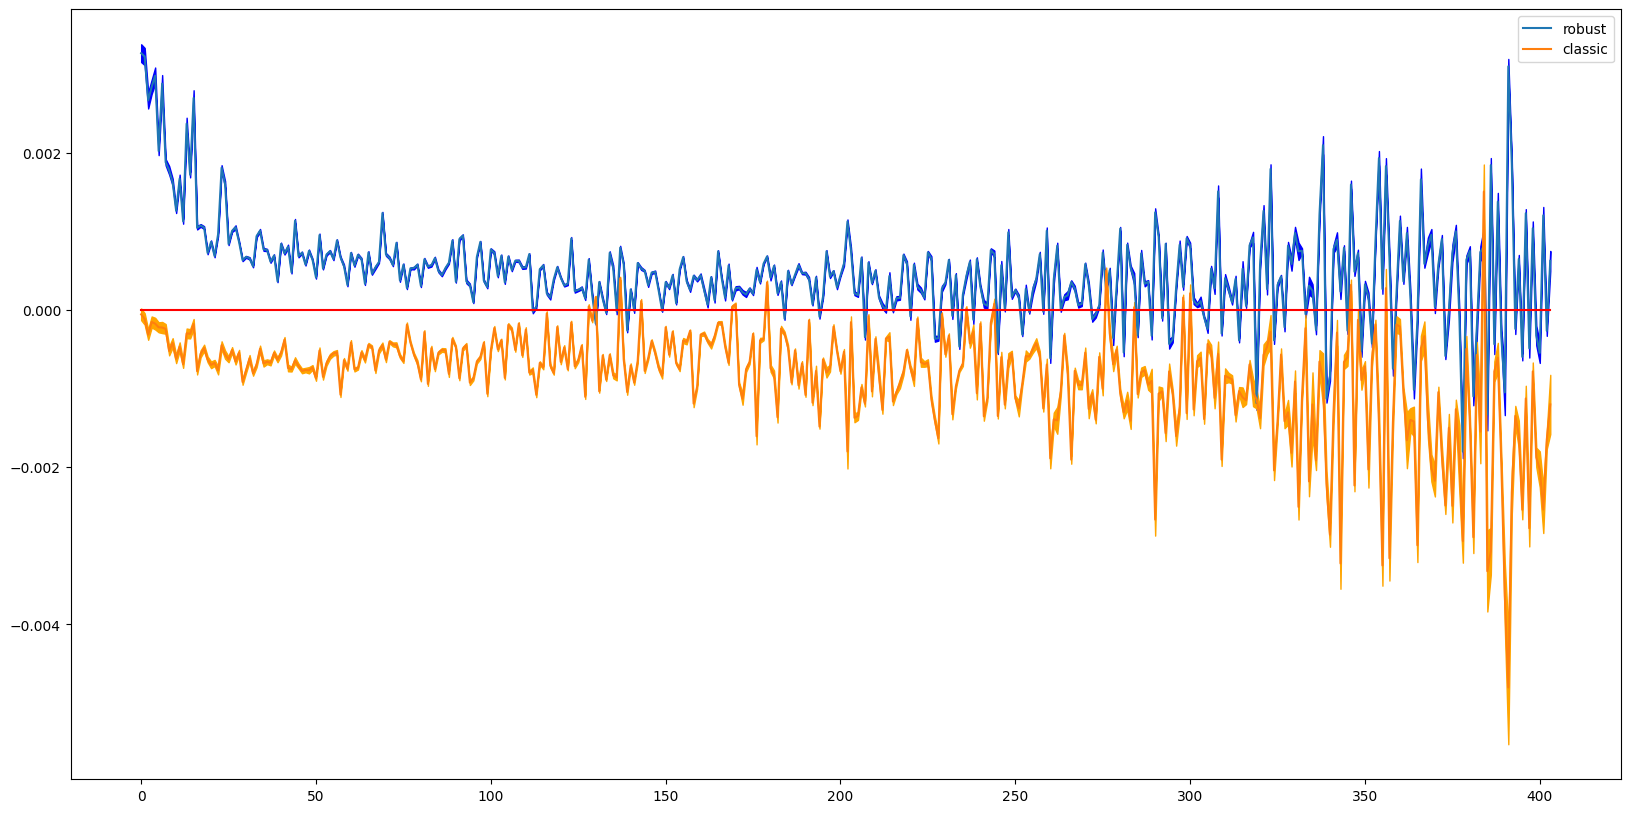

In [29]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),diff1.mean(axis = 1), label = 'robust')
plt.plot(np.arange(404),diff2.mean(axis = 1), label = 'classic')
plt.plot(np.arange(404),np.zeros(404),c = 'r')
plt.fill_between(x=np.arange(404), y1=first_rmse_minus[:,0], y2=first_rmse_plus[:,0], color="blue", alpha=1)
plt.fill_between(x=np.arange(404), y1=first_rmse_minus_2[:,0], y2=first_rmse_plus_2[:,0], color="orange", alpha=1)
plt.legend()


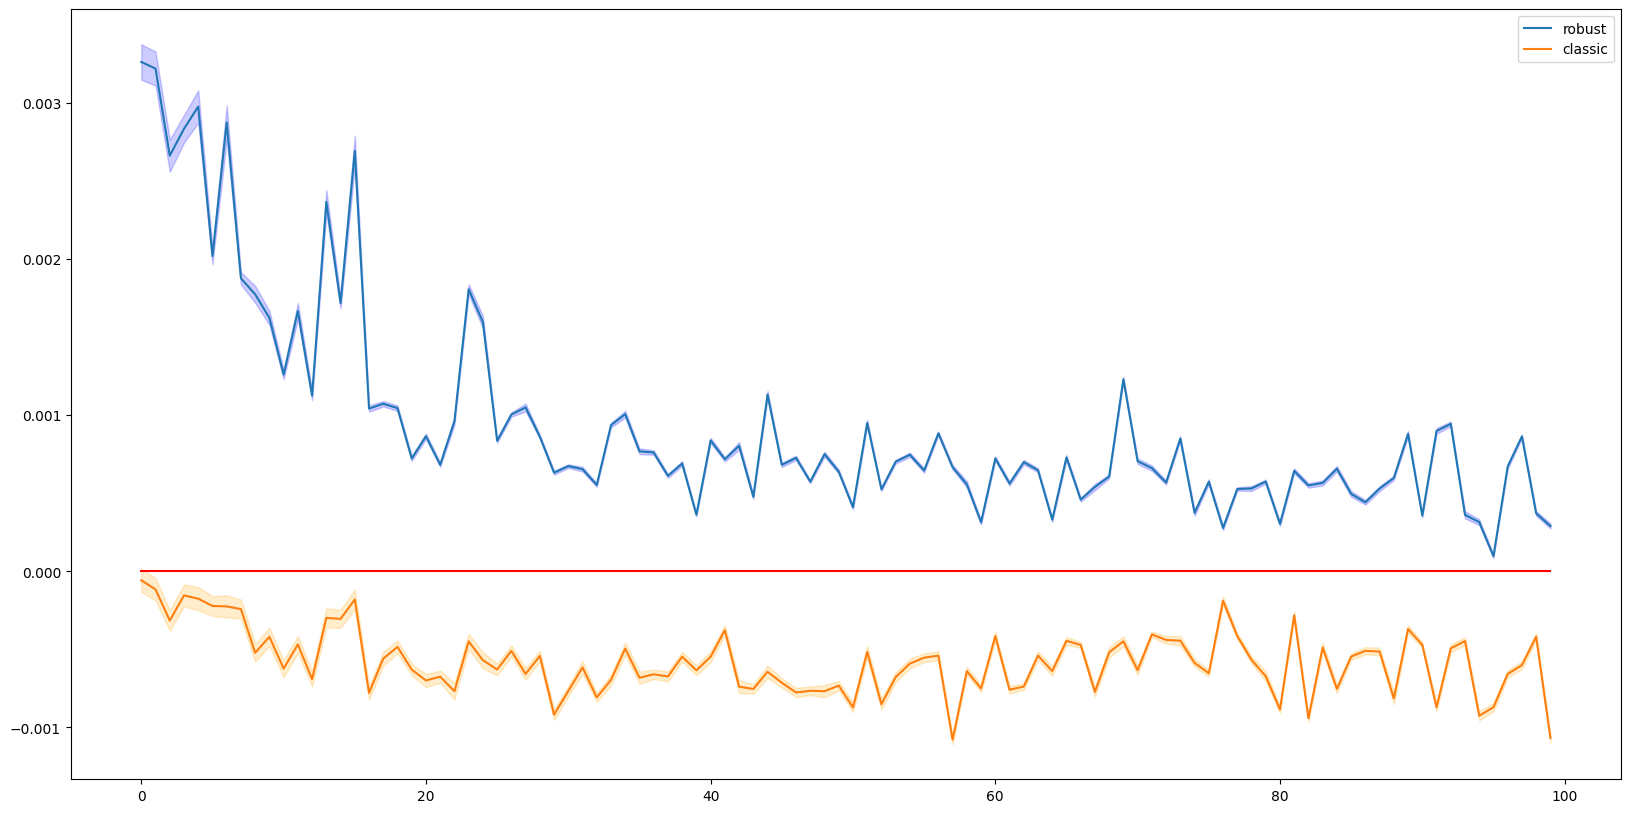

In [30]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(100),diff1.mean(axis = 1)[:100], label = 'robust')
plt.plot(np.arange(100),diff2.mean(axis = 1)[:100], label = 'classic')
plt.plot(np.arange(100),np.zeros(100),c = 'r')
plt.fill_between(x=np.arange(100), y1=first_rmse_minus[:100,0], y2=first_rmse_plus[:100,0], color="blue", alpha=0.2)
plt.fill_between(x=np.arange(100), y1=first_rmse_minus_2[:100,0], y2=first_rmse_plus_2[:100,0], color="orange", alpha=0.2)
plt.legend()


In [ ]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean(),rmse3.mean()}")

rmse predicting only the first iterativelys (0.009623493696984568, 0.00910058380406582, 0.009669378329495716)


In [ ]:
#Silverbox2_fixingcontext_overquery_arrow_noextrap
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)
rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean(),rmse3.mean()}")

In [ ]:
#Silverbox2_fixingcontext_overquery_multisine
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)
rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean(),rmse3.mean()}")

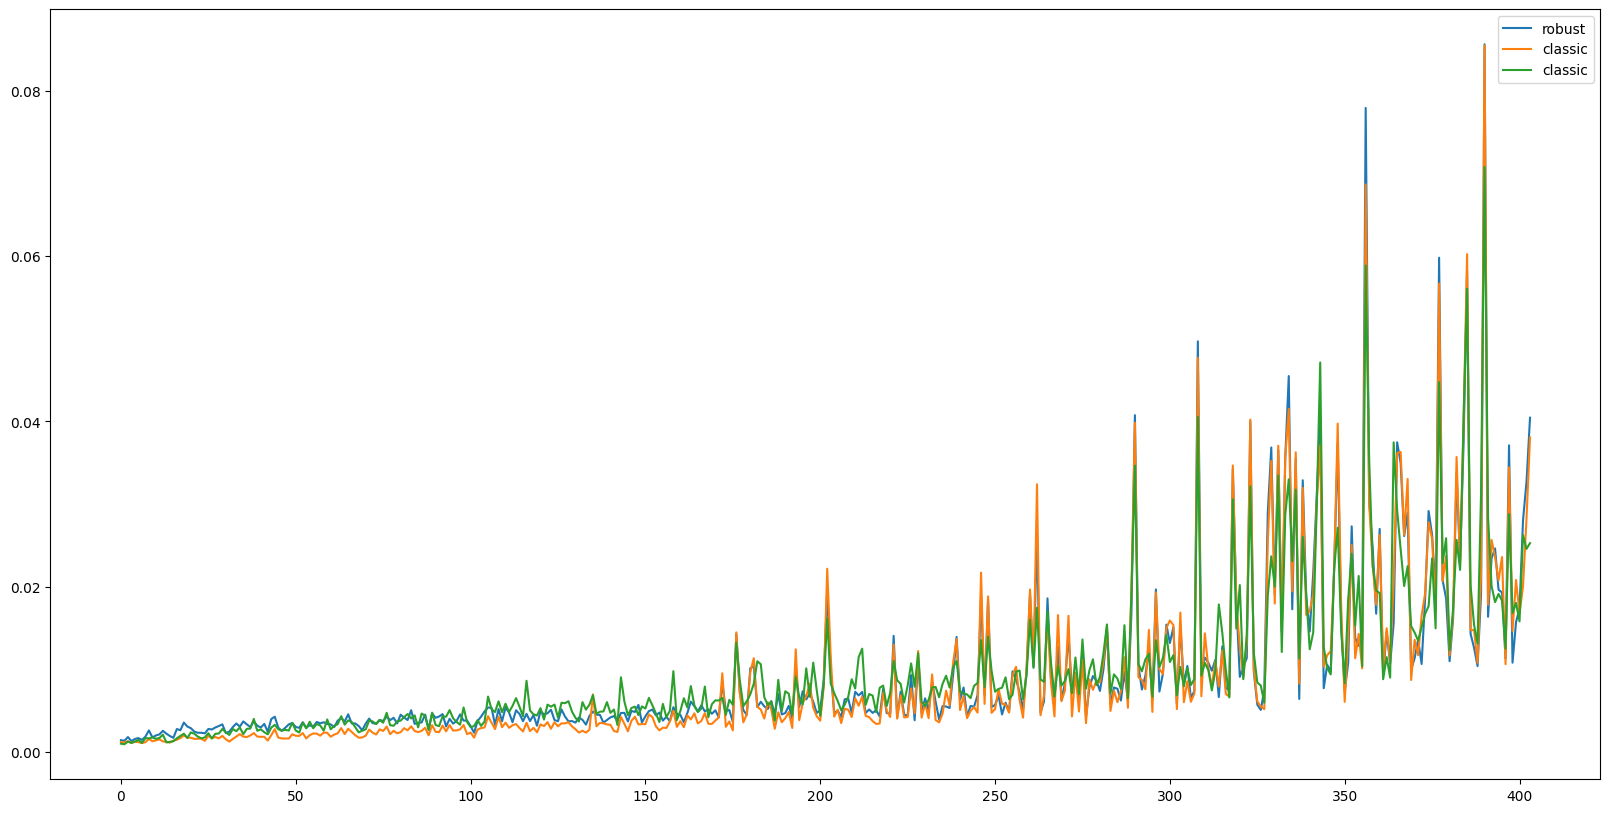

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),rmse1.mean(axis = 1), label = 'robust')
plt.plot(np.arange(404),rmse2.mean(axis = 1), label = 'classic')
plt.plot(np.arange(404),rmse3.mean(axis = 1), label = 'classic')
plt.legend()


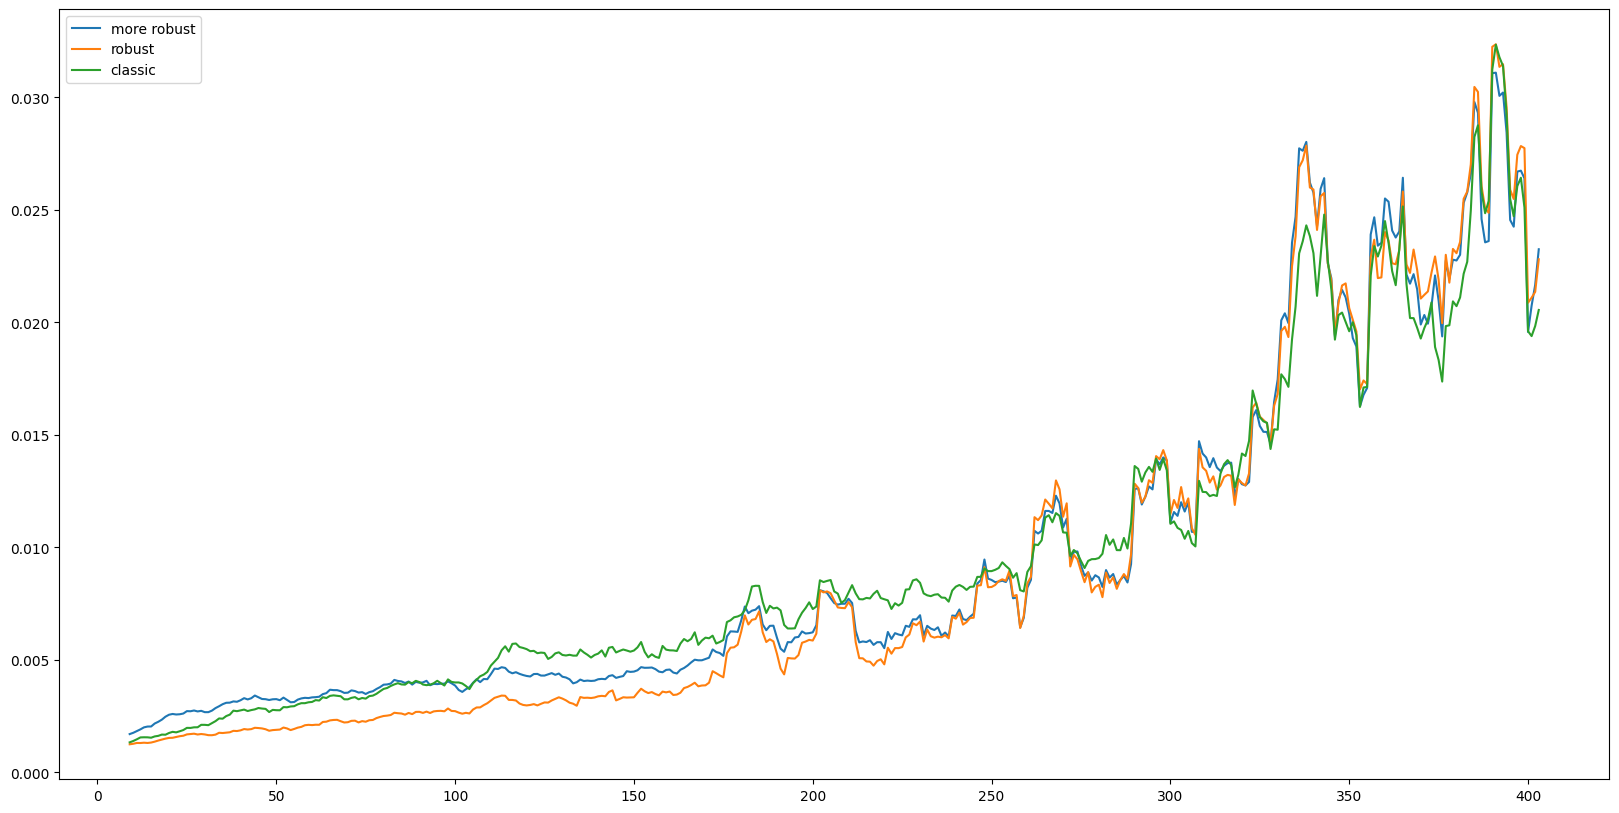

In [ ]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),pd.Series(rmse1.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'more robust')
plt.plot(np.arange(404),pd.Series(rmse2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
plt.plot(np.arange(404),pd.Series(rmse3.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')

plt.legend()


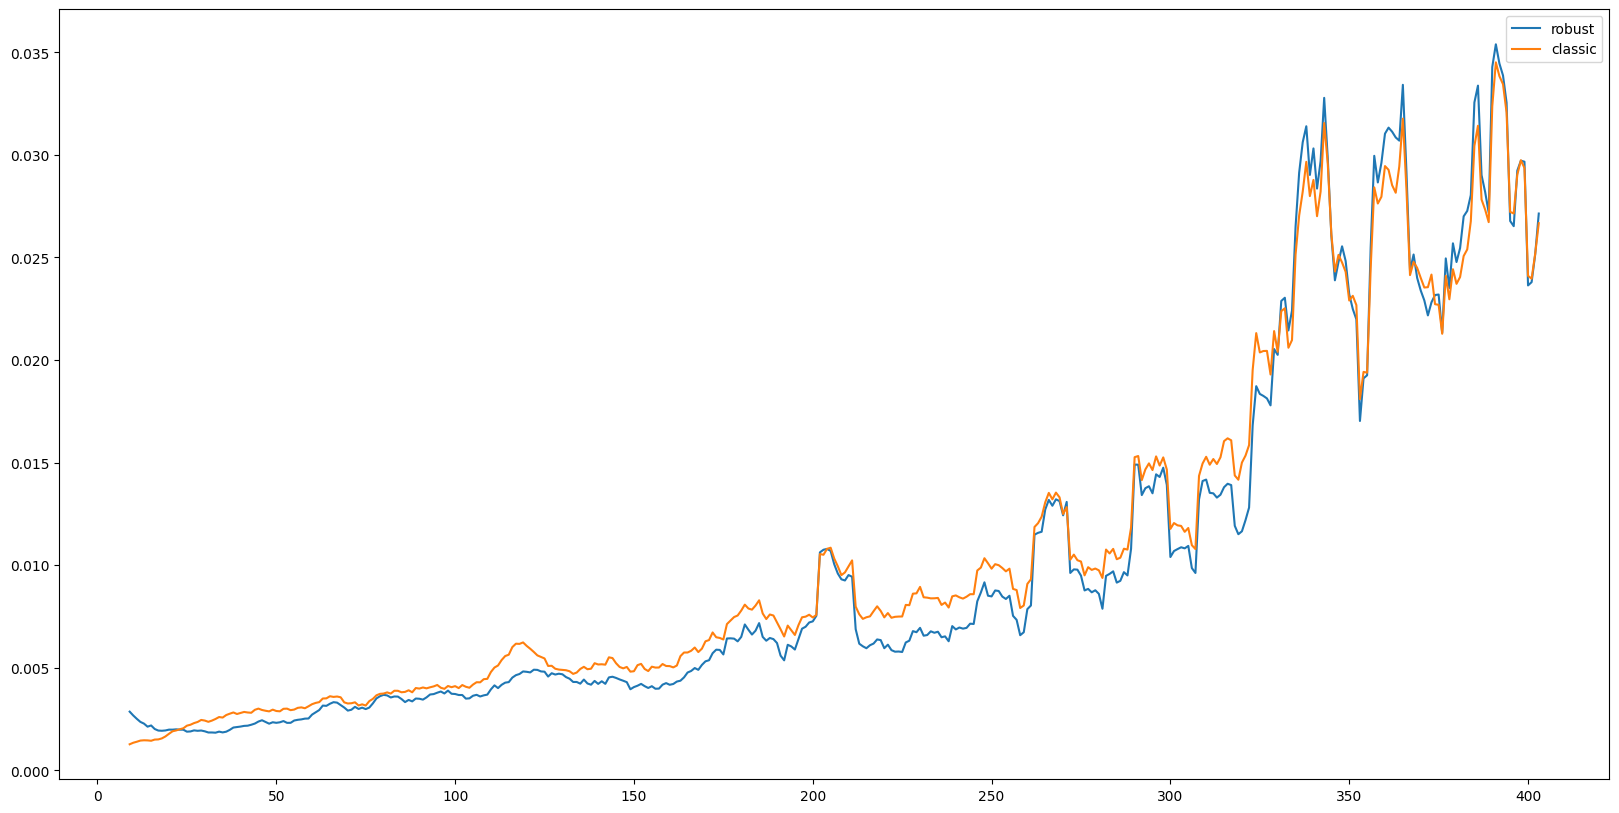

In [20]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),pd.Series(rmse1.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
plt.plot(np.arange(404),pd.Series(rmse2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')

plt.legend()


In [19]:
#Silverbox2_fixingcontext_overquery
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)

first_rmse_plus = rmse1.mean(axis = 1) + rmse1.var(axis = 1) * 3
first_rmse_minus = rmse1.mean(axis = 1) - rmse1.var(axis = 1) * 3

first_rmse_plus_2 = rmse2.mean(axis = 1) + rmse2.var(axis = 1) * 3
first_rmse_minus_2 = rmse2.mean(axis = 1) - rmse2.var(axis = 1) * 3

print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.011057403543869861, 0.010844709891552824)


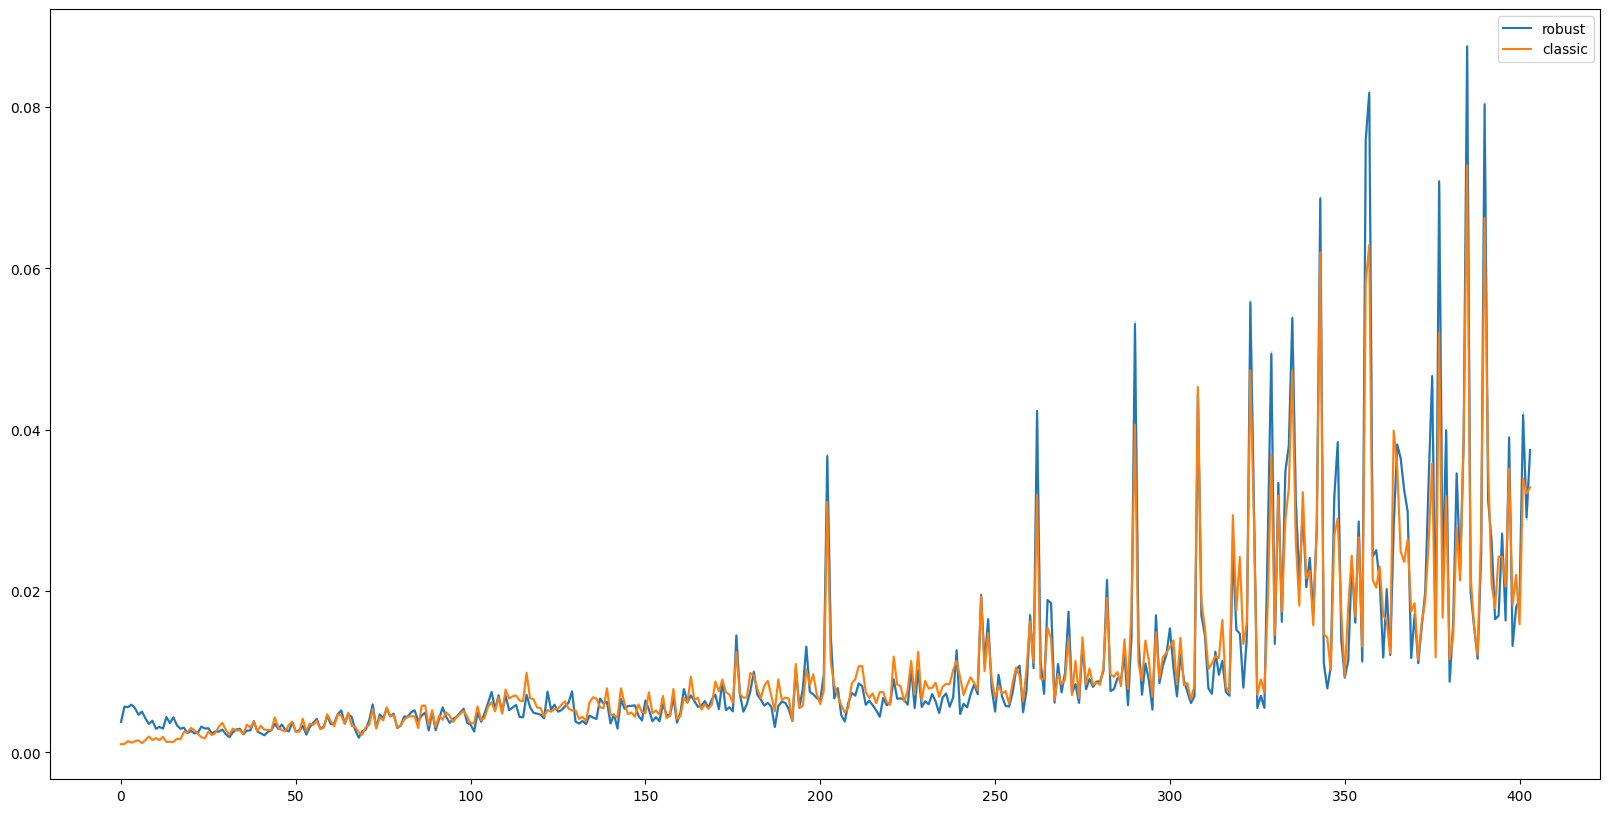

In [20]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),rmse1.mean(axis = 1), label = 'robust')
plt.plot(np.arange(404),rmse2.mean(axis = 1), label = 'classic')
plt.fill_between(x=np.arange(404), y1=first_rmse_minus[:,0], y2=first_rmse_plus[:,0], color="blue", alpha=0.2)
plt.fill_between(x=np.arange(404), y1=first_rmse_minus_2[:,0], y2=first_rmse_plus_2[:,0], color="orange", alpha=0.2)

plt.legend()


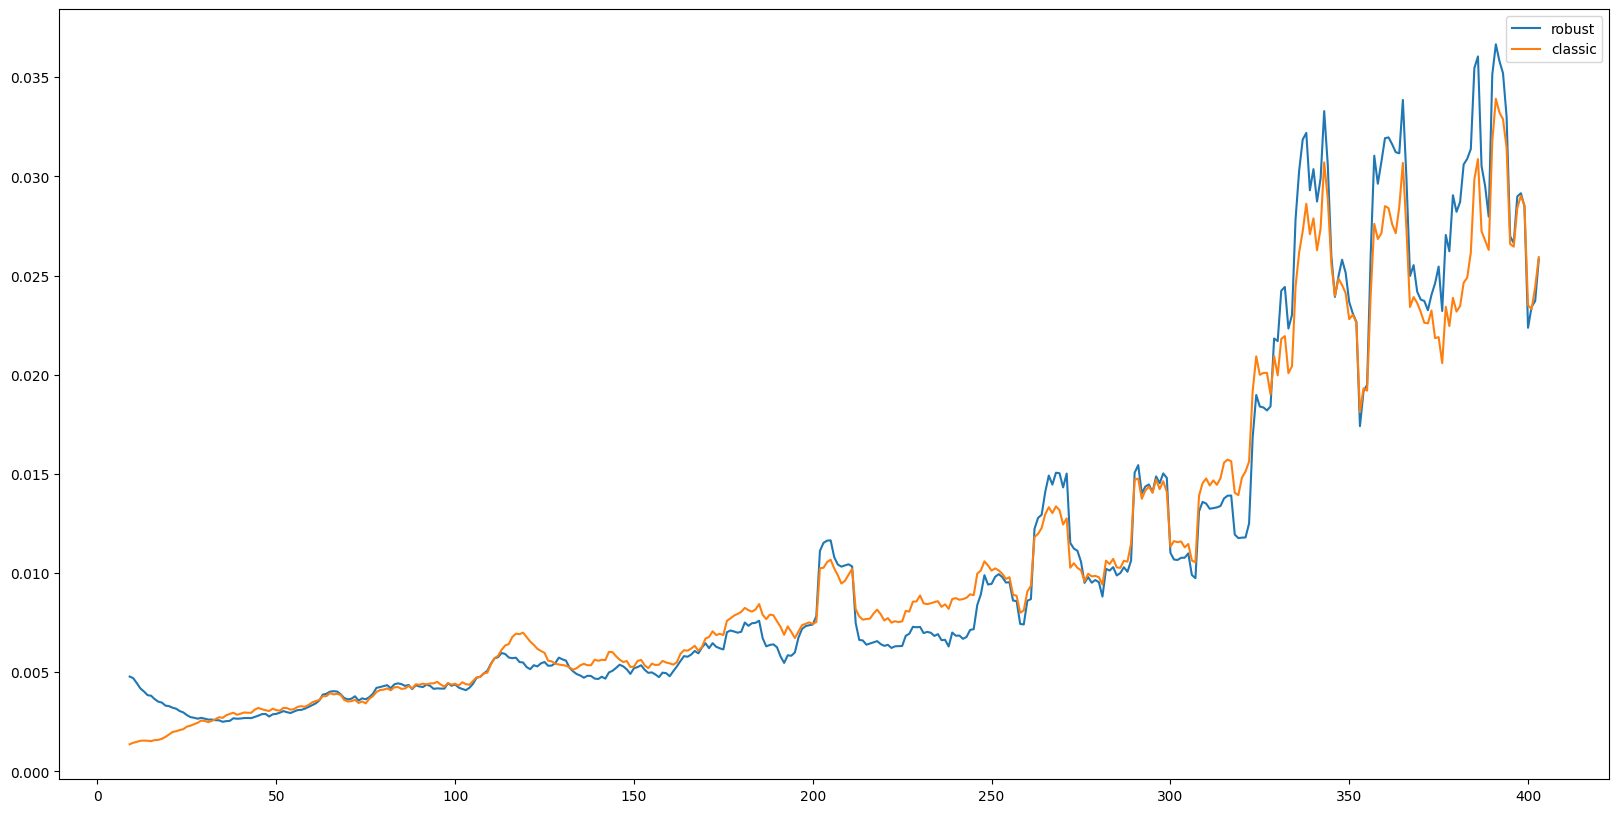

In [21]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),pd.Series(rmse1.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
plt.plot(np.arange(404),pd.Series(rmse2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')

plt.legend()


In [21]:
#Silverbox2_fixingcontext_overquery
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)

first_rmse_plus = rmse1.mean(axis = 1) + rmse1.var(axis = 1) * 3
first_rmse_minus = rmse1.mean(axis = 1) - rmse1.var(axis = 1) * 3

first_rmse_plus_2 = rmse2.mean(axis = 1) + rmse2.var(axis = 1) * 3
first_rmse_minus_2 = rmse2.mean(axis = 1) - rmse2.var(axis = 1) * 3

print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.0086074827459524, 0.009262119748259665)


In [31]:
print(f"rmse predicting only the 0_100 {rmse1[:100].mean(),rmse2[:100].mean(),rmse3[:100].mean()}")
print(f"rmse predicting only the 100_200 {rmse1[100:200].mean(),rmse2[100:200].mean(),rmse3[100:200].mean()}")
print(f"rmse predicting only the 200_300 {rmse1[200:300].mean(),rmse2[200:300].mean(),rmse3[200:300].mean()}")
print(f"rmse predicting only the 300_400 {rmse1[300:404].mean(),rmse2[300:404].mean(),rmse3[300:404].mean()}")

rmse predicting only the 0_100 (0.0024764198885314443, 0.0024661783317867043)
rmse predicting only the 100_200 (0.004071229305204891, 0.0050233381493221515)
rmse predicting only the 200_300 (0.00758176315522626, 0.008820320948858713)
rmse predicting only the 300_400 (0.019850786485274143, 0.020297236877886034)


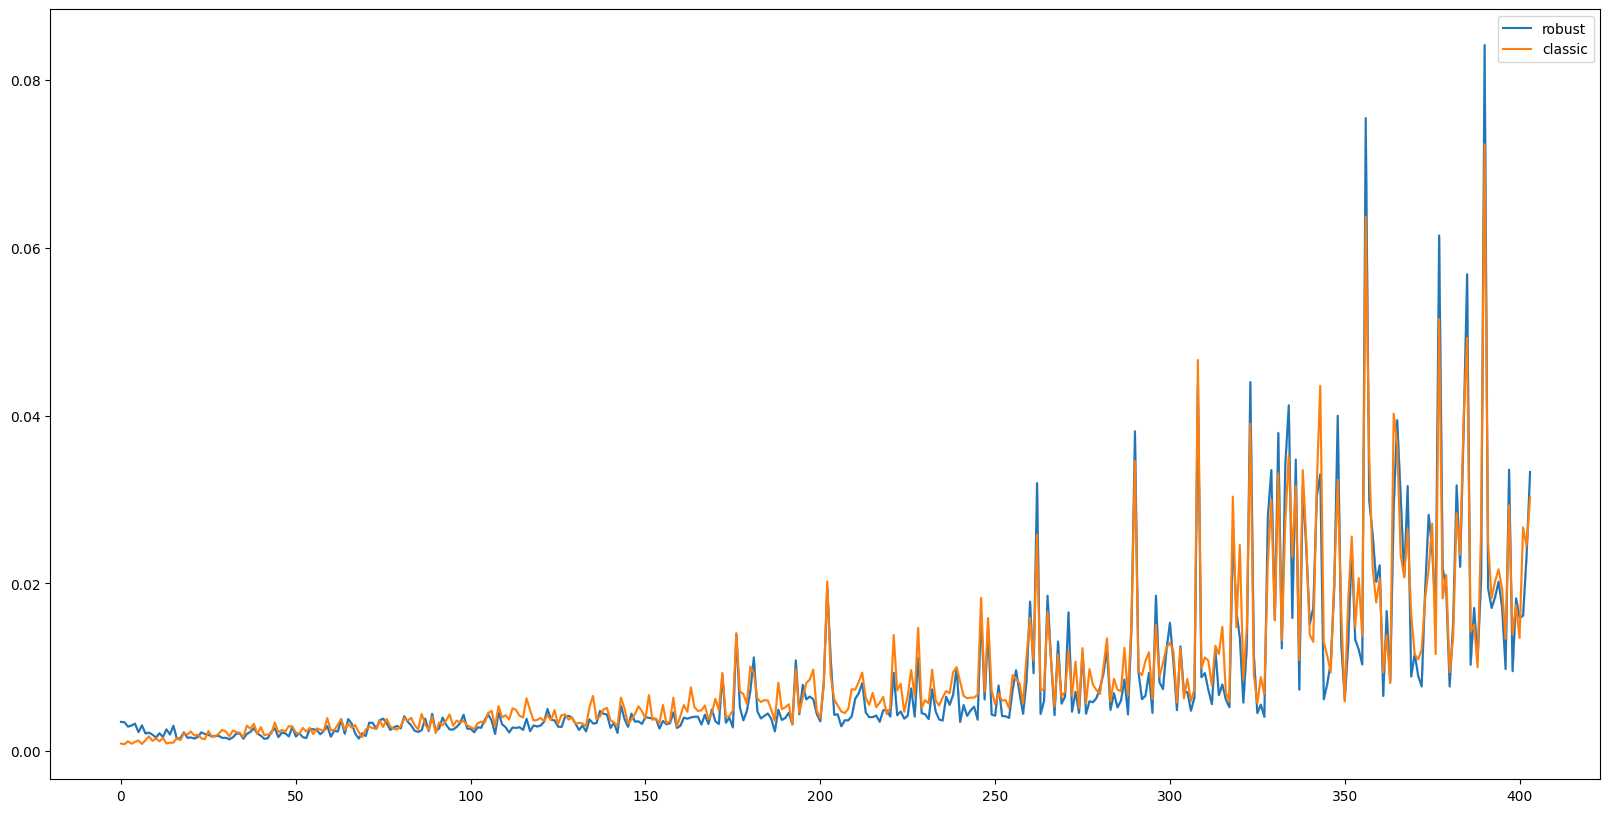

In [22]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(404),rmse1.mean(axis = 1), label = 'robust')
plt.plot(np.arange(404),rmse2.mean(axis = 1), label = 'classic')
plt.fill_between(x=np.arange(404), y1=first_rmse_minus[:,0], y2=first_rmse_plus[:,0], color="blue", alpha=0.2)
plt.fill_between(x=np.arange(404), y1=first_rmse_minus_2[:,0], y2=first_rmse_plus_2[:,0], color="orange", alpha=0.2)

plt.legend()


In [18]:
#Silverbox2_fixingcontext_overquery
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.020102603766602112, 0.021991435598086244)


In [23]:
#Silverbox1
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.003932013294134523, 0.005488171824454848)


In [12]:
#Silverbox2_overcontext_fxingquery
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.003504470288963262, 0.0009214944022039609)


In [13]:
rmse1[:10],rmse2[:10]

(array([[0.00330785],
        [0.00396728],
        [0.00370843],
        [0.00470866],
        [0.00455519],
        [0.00250779],
        [0.0042412 ],
        [0.00447715],
        [0.00294239],
        [0.00283102]]),
 array([[0.00080249],
        [0.00110782],
        [0.00089939],
        [0.0015924 ],
        [0.00094765],
        [0.00081087],
        [0.00092715],
        [0.0008401 ],
        [0.00074004],
        [0.00115091]]))

In [24]:
#Silverbox3
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.006548591732070702, 0.010480348751431617)


In [ ]:
#WH
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

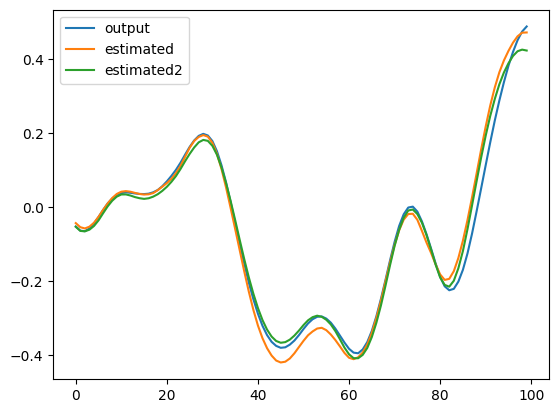

In [14]:
# plt.plot(np.arange(100),test_u_1[0,:,0], label = 'input')
plt.plot(np.arange(100),test_y_1[0,:,0], label = 'output')
plt.plot(np.arange(100),estimate_mean_y_1[3,:,0],label = 'estimated')
plt.plot(np.arange(100),estimate_mean_y_1_2[5,:,0],label = 'estimated2')

plt.legend()

In [ ]:
skip = 0
rmse1 = metrics.rmse_test(test_y_1[:,4:,:], estimate_mean_y_1[:,4:,:], time_axis=1)
rmse2 = metrics.rmse_test(test_y_2[:,4:,:], estimate_mean_y_2[:,4:,:], time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.08074542977448965, 0.29155639494120905)


In [16]:
skip = 0
rmse2 = metrics.rmse_test(test_y_1[:,4:,:], estimate_mean_y_1[:,4:,:], time_axis=1)
rmse2_2 = metrics.rmse_test(test_y_2[:,4:,:], estimate_mean_y_2[:,4:,:], time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse2.mean(),rmse2_2.mean()}")

rmse predicting only the first iterativelys (0.10297262033577459, 0.2824365359603541)


In [17]:
skip = 0
rmse = metrics.rmse_test(test_y_1[:,4:,:], estimate_mean_y_1_2[:,4:,:], time_axis=1)
rmse_2 = metrics.rmse_test(test_y_2[:,4:,:], estimate_mean_y_2_2[:,4:,:], time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse.mean(),rmse_2.mean()}")


rmse predicting only the first iterativelys (0.11583252636690416, 0.15070868705424173)


In [ ]:
skip = 0
rmse = metrics.rmse_test(test_y_1[:,4:,:], estimate_mean_y_1_2[:,4:,:], time_axis=1)
rmse_2 = metrics.rmse_test(test_y_2[:,4:,:], estimate_mean_y_2_2[:,4:,:], time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse.mean(),rmse_2.mean()}")


rmse predicting only the first iterativelys (0.36082721546968705, 0.7094429865037031)


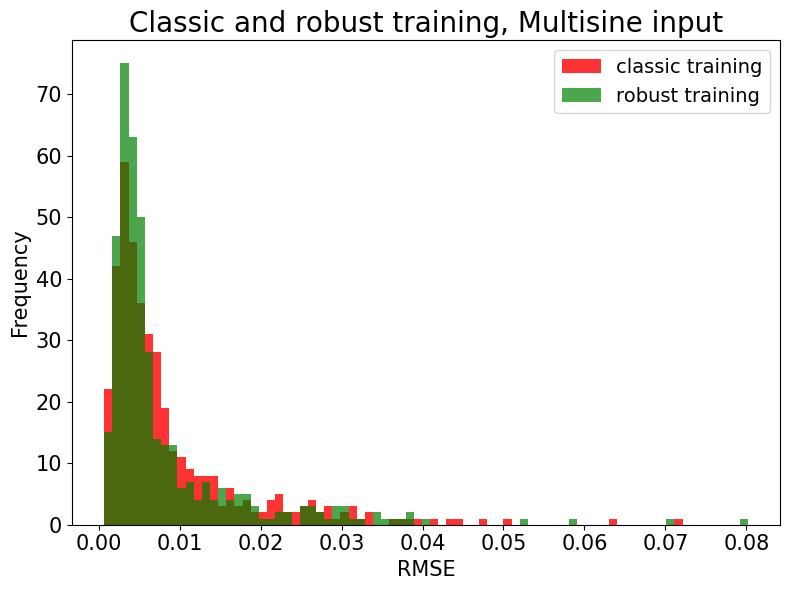

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse1.min())
max_edge = max(rmse2.max(), rmse1.max())
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse1, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, Multisine input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# # Add an inset zoomed plot
# inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
#                       bbox_transform=ax.transAxes)  # Adjust size and position
# inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
# inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# # Zoom in on x > 0.2 for the inset
# inset_ax.set_xlim(0.4, rmse2.max())
# # Calculate the max y value in the zoomed-in area
# hist_classic, _ = np.histogram(rmse2, bins=bins)
# hist_robust, _ = np.histogram(rmse, bins=bins)
# filtered_indices = bins[:-1] > 0.4
# max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
# inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# # Add labels to inset for clarity
# inset_ax.set_title('Tail region', fontsize = 20)
# inset_ax.tick_params(axis='both', labelsize=15)

# # Optionally, draw a rectangle to indicate the zoomed region on the main plot
# rect_x = [0.4, rmse2.max(), rmse2.max(), 0.4, 0.4]
# rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
# ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
# plt.savefig('fig_robustL/Multisine_comparison.pdf')
plt.show()

In [16]:
#Silverbox2
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=1)
rmse2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=1)
print(f"rmse predicting only the first iterativelys {rmse1.mean(),rmse2.mean()}")

rmse predicting only the first iterativelys (0.003504470288963262, 0.0009214944022039609)


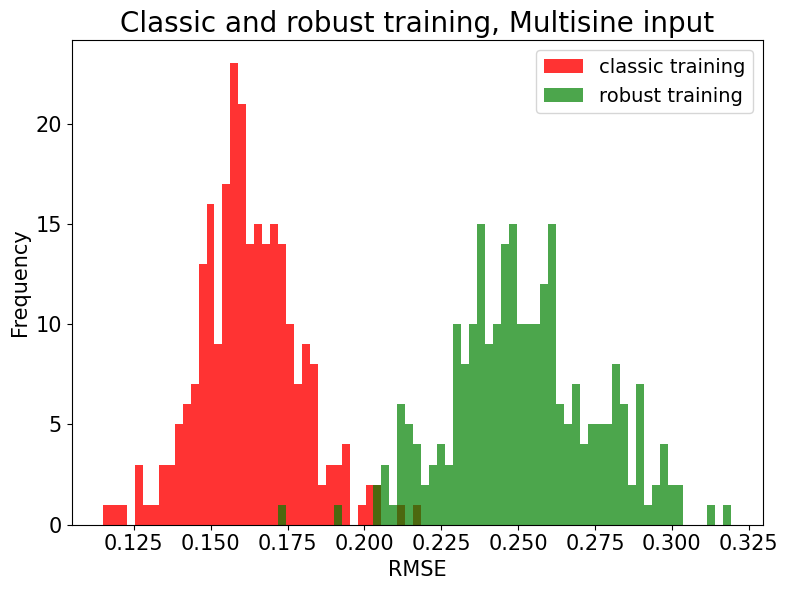

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse_2.min(), rmse2_2.min())
max_edge = max(rmse_2.max(), rmse2_2.max())
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse_2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse2_2, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, Multisine input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# # Add an inset zoomed plot
# inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
#                       bbox_transform=ax.transAxes)  # Adjust size and position
# inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
# inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# # Zoom in on x > 0.2 for the inset
# inset_ax.set_xlim(0.4, rmse2.max())
# # Calculate the max y value in the zoomed-in area
# hist_classic, _ = np.histogram(rmse2, bins=bins)
# hist_robust, _ = np.histogram(rmse, bins=bins)
# filtered_indices = bins[:-1] > 0.4
# max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
# inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# # Add labels to inset for clarity
# inset_ax.set_title('Tail region', fontsize = 20)
# inset_ax.tick_params(axis='both', labelsize=15)

# # Optionally, draw a rectangle to indicate the zoomed region on the main plot
# rect_x = [0.4, rmse2.max(), rmse2.max(), 0.4, 0.4]
# rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
# ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
# plt.savefig('fig_robustL/Multisine_comparison.pdf')
plt.show()

In [ ]:
# Create data loader
lin_opts = dict(mag_range=cfg.mag_range, phase_range=cfg.phase_range, strictly_proper=True)
# if out_dir_name[-5:] == 'query':
# test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
#                                         seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
#                         system_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2,
#                         **lin_opts)
# else:
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
                                        seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
                        system_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2,
                        **lin_opts)
# test_ds = CSTRDataset_numba(seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
#                     shift_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2)
# test_ds = LinearDynamicalDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=cfg.seq_len_ctx+cfg.seq_len_new)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1)

In [ ]:
batch_y, batch_u= next(iter(test_dl))
# print(batch_u.mean(axis = 1),batch_u.std(axis = 1))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
# batch_whitenoise = batch_whitenoise.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    # batch_y_ctx = batch_y_ctx + torch.randn(batch_y_ctx.shape)*noise_std
    # print(batch_y_ctx.shape)
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    for i in range(len(batch_y_ctx[0,0,:])):
        # print(i)
        print(batch_y_ctx[:,:,i:i+1].shape)
        batch_y_mean[:,:,i:i+1], batch_y_std, _, _, nll = model(batch_y_ctx[:,:,i:i+1], batch_u_ctx, batch_u_new[:,:,:],batch_y_new[:,:,i:i+1],cfg.seq_len_n_in)
print(cfg.seq_len_n_in)

torch.Size([2048, 400, 1])
30


In [ ]:
batch_y, batch_u= next(iter(test_dl))
# print(batch_u.mean(axis = 1),batch_u.std(axis = 1))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
# batch_whitenoise = batch_whitenoise.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    # batch_y_ctx = batch_y_ctx + torch.randn(batch_y_ctx.shape)*noise_std
    # print(batch_y_ctx.shape)
    batch_y_mean2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    batch_y_std2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    for i in range(len(batch_y_ctx[0,0,:])):
        # print(i)
        print(batch_y_ctx[:,:,i:i+1].shape)
        batch_y_mean2[:,:,i:i+1], batch_y_std2, _, _, nll2 = model2(batch_y_ctx[:,:,i:i+1], batch_u_ctx, batch_u_new[:,:,:],batch_y_new[:,:,i:i+1],cfg.seq_len_n_in)
print(cfg.seq_len_n_in)

torch.Size([2048, 400, 1])
30


In [ ]:
ctx_y_var = [torch.var(batch_y_ctx[i,:]) for i in range(batch_size)]
new_y_var = [torch.var(batch_y_new[i,:]) for i in range(batch_size)]

In [ ]:
print(ctx_y_var,new_y_var)

[tensor(1.0492), tensor(1.2006), tensor(1.0796), tensor(1.0373), tensor(0.8883), tensor(0.9661), tensor(0.5244), tensor(1.0057), tensor(0.9531), tensor(1.1368), tensor(0.9412), tensor(0.9131)] [tensor(0.8756), tensor(0.6005), tensor(0.9033), tensor(1.0016), tensor(1.2392), tensor(0.8002), tensor(1.8474), tensor(0.6455), tensor(1.1734), tensor(0.3084), tensor(0.9554), tensor(1.3169)]


In [ ]:
arange_tensor = torch.arange(batch_y_ctx.squeeze(-1).shape[1]).unsqueeze(1).float()  # Shape: (400, 1)
arange_tensor = arange_tensor.repeat(1, 2)  # Shape: (400, 2)

# The first column is `arange(400)`, and the second column is the original batch values
batch_u_ctx_expanded = batch_y_ctx.repeat(1, 1, 2)  # Shape: (150, 400, 2)

# Set the first column to `arange(400)`
batch_u_ctx_expanded[:, :, 0] = arange_tensor[:, 0]

# Now `expanded_batch` is the desired tensor of shape (150, 400, 2)
print(batch_u_ctx_expanded.shape)  # Output: torch.Size([150, 400, 2])


torch.Size([12, 400, 2])


In [ ]:
arange_tensor = torch.arange(batch_y_new.squeeze(-1).shape[1]).unsqueeze(1).float()  # Shape: (400, 1)
arange_tensor = arange_tensor.repeat(1, 2)  # Shape: (400, 2)

# The first column is `arange(400)`, and the second column is the original batch values
batch_u_new_expanded = batch_y_new.repeat(1, 1, 2)  # Shape: (150, 400, 2)

# Set the first column to `arange(400)`
batch_u_new_expanded[:, :, 0] = arange_tensor[:, 0]

# Now `expanded_batch` is the desired tensor of shape (150, 400, 2)
print(batch_u_new_expanded.shape)  # Output: torch.Size([150, 400, 2])


torch.Size([12, 130, 2])


In [ ]:
_, indices_2 = torch.topk(torch.exp(-nll).mean(axis = 1).view(-1),k = 256, largest = False)

In [ ]:
batch_y_mean = batch_y_mean[:, :, :].to("cpu").detach().numpy()
batch_y_std = batch_y_std[:,:, :].to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()

In [ ]:
batch_sim_err = batch_y_new[:, cfg.seq_len_n_in:100+cfg.seq_len_n_in, :] - batch_y_mean[:, :100, :]
batch_y_plus = batch_y_mean + batch_y_std * 3
batch_y_minus = batch_y_mean - batch_y_std * 3

In [ ]:
t = np.arange(1, batch_u_new.shape[1]-cfg.seq_len_n_in+1)+cfg.seq_len_n_in + cfg.seq_len_ctx+cfg.seq_len_skip

In [ ]:
batch_y_mean2 = batch_y_mean2[:, :, :].to("cpu").detach().numpy()
batch_y_std2 = batch_y_std2[:,:, :].to("cpu").detach().numpy()
batch_sim_err2 = batch_y_new[:, cfg.seq_len_n_in:100+cfg.seq_len_n_in, :] - batch_y_mean2[:, :100, :]
batch_y_plus2 = batch_y_mean2 + batch_y_std2 * 3
batch_y_minus2 = batch_y_mean2 - batch_y_std2 * 3

(array([3., 4., 1., 3., 0., 0., 0., 0., 0., 1.]),
 array([0.14626685, 0.2070621 , 0.26785734, 0.32865259, 0.38944784,
        0.45024312, 0.51103836, 0.57183361, 0.63262886, 0.69342411,
        0.75421935]),
 <BarContainer object of 10 artists>)

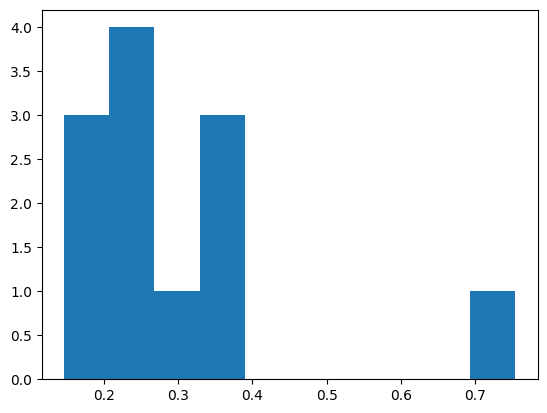

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
plt.hist(rmse)
# plt.hist(results)

# MULTISINE ERR 0.01

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(),rmse2.mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.12987432, 0.15144908)


/tmp/ipykernel_885404/2876913432.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


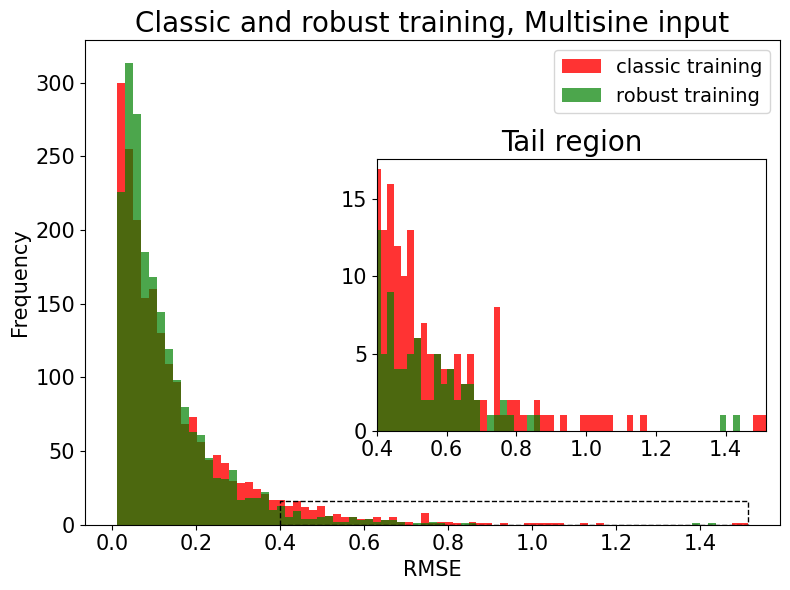

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, Multisine input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.4, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.4
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.4, rmse2.max(), rmse2.max(), 0.4, 0.4]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
plt.savefig('fig_robustL/Multisine_comparison.pdf')
plt.show()

In [ ]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = 256, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = 256, largest = True)

In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.39621794, 0.4853741)


In [ ]:
rmse_1 = rmse[rmse >= 0.5]
rmse2_1 = rmse2[rmse2 >= 0.5]

Text(0.5, 1.0, 'Comparison between classic and robust training multisine')

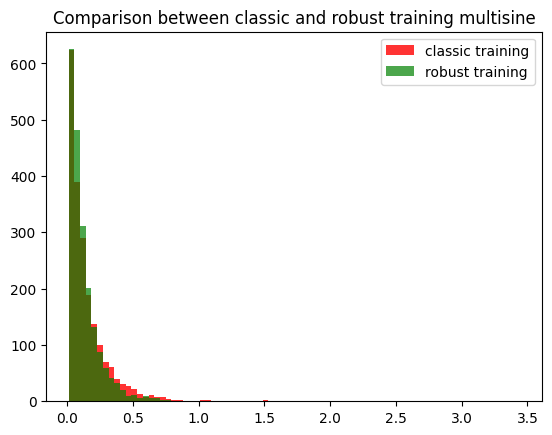

In [ ]:
min_edge = min(rmse2.min(), rmse.min())
max_edge = max(rmse2.max(), rmse.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training multisine')

Text(0.5, 1.0, 'Comparison between tails classic and robust training multisine')

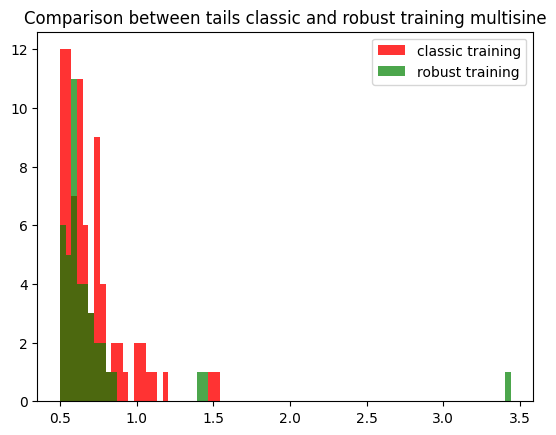

In [ ]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between tails classic and robust training multisine')

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse random choice over 64 on mutlisine {rmse.mean()}")

rmse random choice over 64 on mutlisine 0.2848857045173645


# MULTISINE ERR 0.1

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on mutltisine input err 0.1 {rmse.mean()}")

rmse paper top 32 over 64 on mutltisine input err 0.1 0.07060497999191284


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse top 32 over 64 on mutltisine input err 0.1 {rmse.mean()}")

rmse top 32 over 64 on mutltisine input err 0.1 0.20106324553489685


Text(0.5, 1.0, ' paper top 32 choice over 64 multisine 0.1 err')

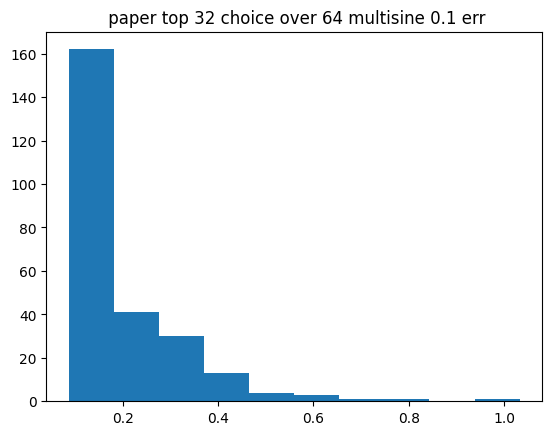

In [ ]:
plt.hist(rmse)
plt.title(' paper top 32 choice over 64 multisine 0.1 err')


Text(0.5, 1.0, 'top 32 choice over 64 multisine 0.1 err')

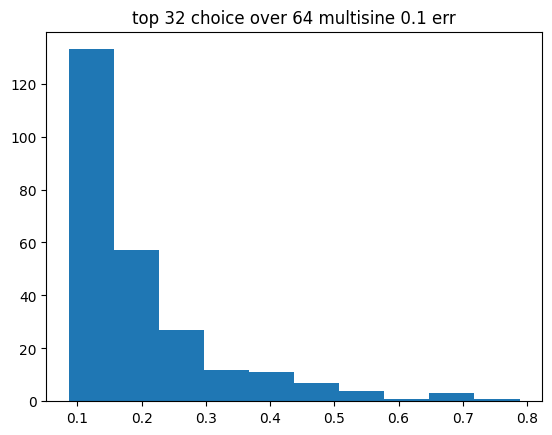

In [ ]:
plt.hist(rmse)
plt.title('top 32 choice over 64 multisine 0.1 err')


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on mutltisine input err 0.1 {rmse.mean()}")

rmse rand 32 over 64 on mutltisine input err 0.1 0.20696920156478882


Text(0.5, 1.0, 'rand 32 choice over 64 multisine 0.1 err')

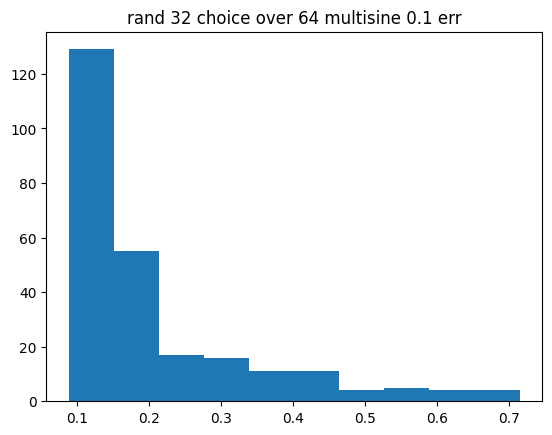

In [ ]:
plt.hist(rmse)
plt.title('rand 32 choice over 64 multisine 0.1 err')


# WHITE NOISE ERR 0.01


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(),rmse2.mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.07060498, 0.087835744)


/tmp/ipykernel_1035261/531206438.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


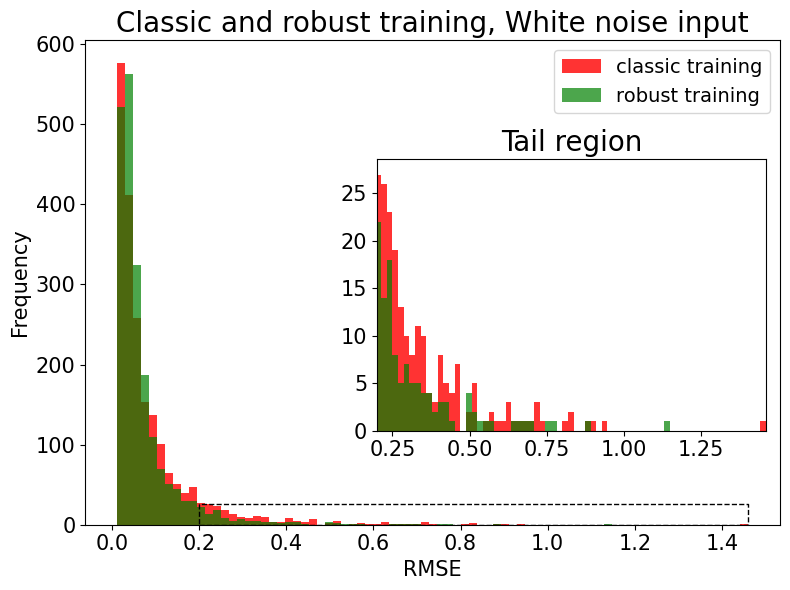

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, White noise input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.2, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.2
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.2, rmse2.max(), rmse2.max(), 0.2, 0.2]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
plt.savefig('fig_robustL/WN_comparison.pdf')
plt.show()

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(),rmse2.mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.07060498, 0.087835744)


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse top 32 over 64 on whitenoise input {rmse.mean()}")

rmse top 32 over 64 on whitenoise input 0.07060497999191284


In [ ]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = 256, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = 256, largest = True)

In [ ]:
rmse_1 = rmse[rmse >= 0.2]
rmse2_1 = rmse2[rmse2 >= 0.2]


In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.23287594, 0.31331992)


Text(0.5, 1.0, 'Comparison between classic and robust training white noise')

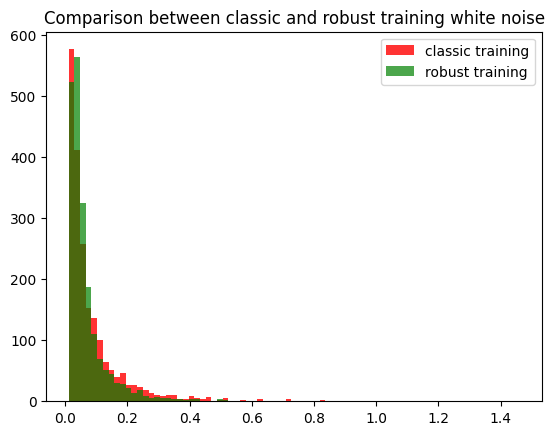

In [ ]:
min_edge = min(rmse2.min(), rmse.min())
max_edge = max(rmse2.max(), rmse.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')

Text(0.5, 1.0, 'Comparison between classic and robust training white noise')

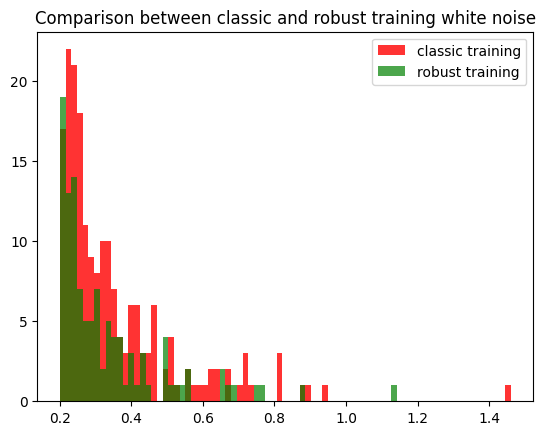

In [ ]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')

Text(0.5, 1.0, 'top 32 choice over 64 whitenoise')

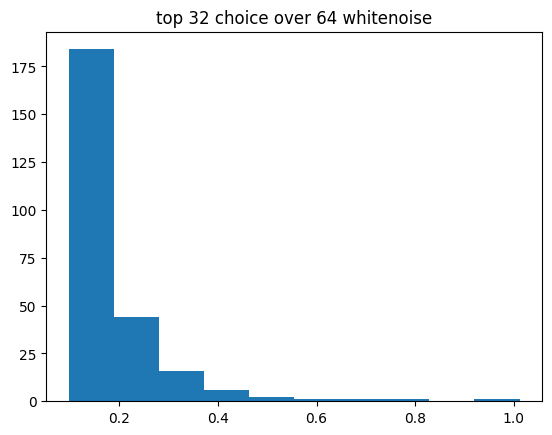

In [ ]:
plt.hist(rmse)
plt.title('top 32 choice over 64 whitenoise')


In [ ]:
_, indices_2 =torch.topk(torch.tensor(rmse),k = 256, largest = True)

0.31870818


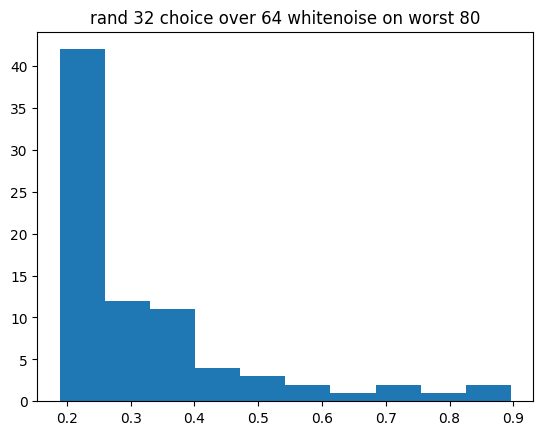

In [ ]:
plt.hist(rmse[indices_2[:80]])
plt.title('rand 32 choice over 64 whitenoise on worst 80')
print(rmse[indices_2[:80]].mean())

Text(0.5, 1.0, 'rand 32 choice over 64 whitenoise')

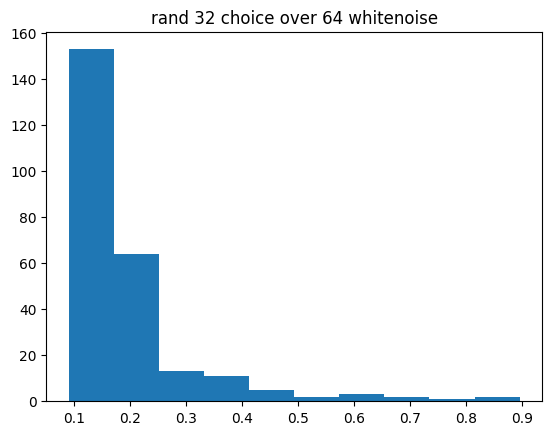

In [ ]:
plt.hist(rmse)
plt.title('rand 32 choice over 64 whitenoise')


# WHITE NOISE ERR 0.1


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.1 err {rmse.mean()}")

rmse paper top 32 over 64 on whitenoise input 0.1 err 0.1502712219953537


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse top 32 over 64 on whitenoise input 0.1 err {rmse.mean()}")

rmse top 32 over 64 on whitenoise input 0.1 err 0.14445960521697998


In [ ]:
_, indices_2 =torch.topk(torch.tensor(rmse),k = 256, largest = True)

0.20858248


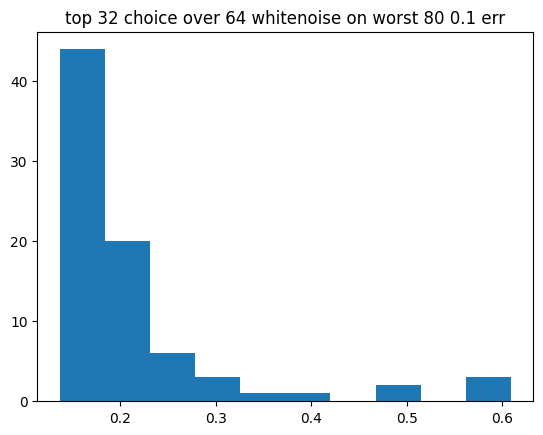

In [ ]:
plt.hist(rmse[indices_2[:80]])
plt.title('top 32 choice over 64 whitenoise on worst 80 0.1 err')
print(rmse[indices_2[:80]].mean())

0.22190504


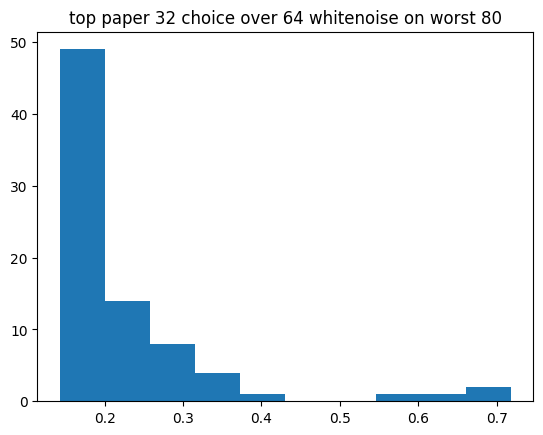

In [ ]:
plt.hist(rmse[indices_2[:80]])
plt.title('top paper 32 choice over 64 whitenoise on worst 80')
print(rmse[indices_2[:80]].mean())

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on whitenoise input 01 err {rmse.mean()}")

rmse rand 32 over 64 on whitenoise input 01 err 0.14873561263084412


0.22301021


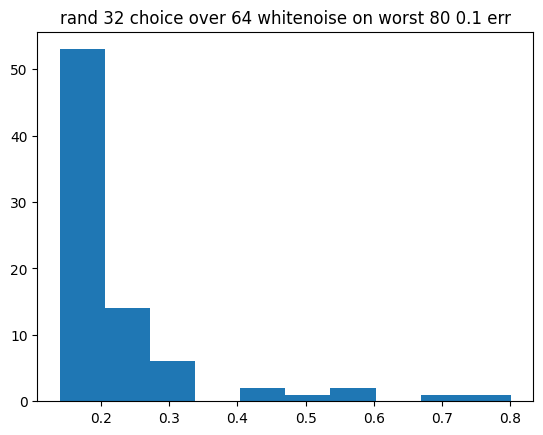

In [ ]:
plt.hist(rmse[indices_2[:80]])
plt.title('rand 32 choice over 64 whitenoise on worst 80 0.1 err')
print(rmse[indices_2[:80]].mean())

# PRBS ERR 0.01

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(),rmse2.mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.22278416, 0.23164846)


/tmp/ipykernel_884783/3884686719.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


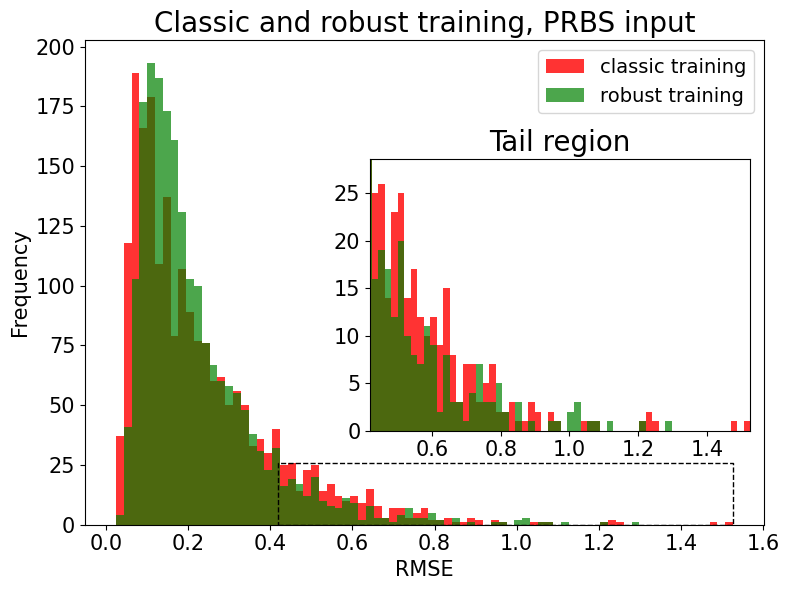

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, PRBS input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.42, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.42
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.42, rmse2.max(), rmse2.max(), 0.42, 0.42]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
plt.savefig('fig_robustL/PRBS_comparison.pdf')
plt.show()

In [ ]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = 256, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = 256, largest = True)

In [ ]:
rmse_1 = rmse[rmse >= 0.5]
rmse2_1 = rmse2[rmse2 >= 0.5]

In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.54729426, 0.60365915)


Text(0.5, 1.0, 'Comparison between classic and robust training prbs')

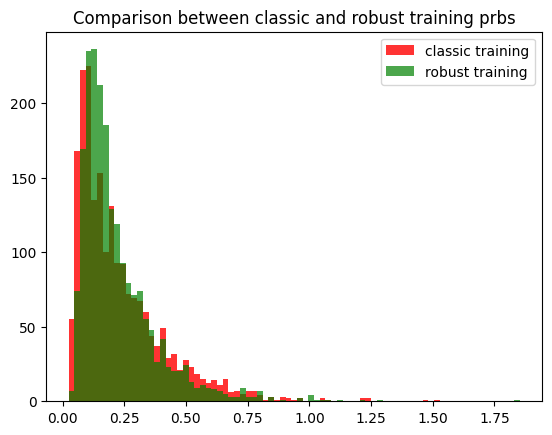

In [ ]:
min_edge = min(rmse2.min(), rmse.min())
max_edge = max(rmse2.max(), rmse.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training prbs')

Text(0.5, 1.0, 'Comparison between classic and robust training white noise')

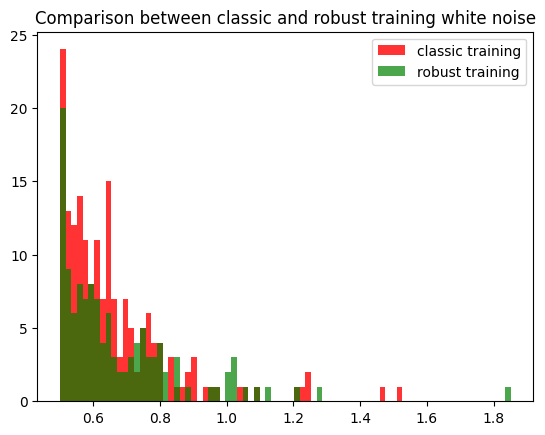

In [ ]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')

Text(0.5, 1.0, 'top paper 32 choice over 64 prbs 0.01 err')

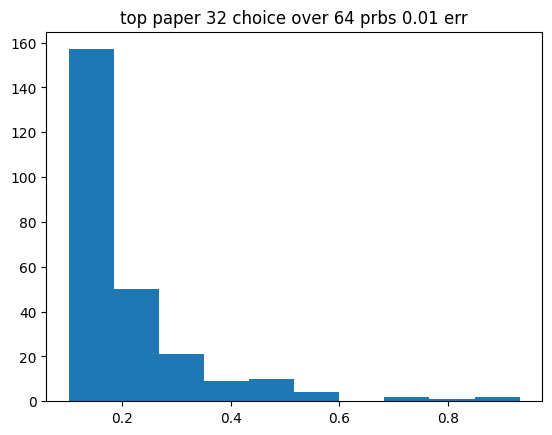

In [ ]:
plt.hist(rmse)
plt.title('top paper 32 choice over 64 prbs 0.01 err')


Text(0.5, 1.0, 'top 32 choice over 64 prbs 0.01 err')

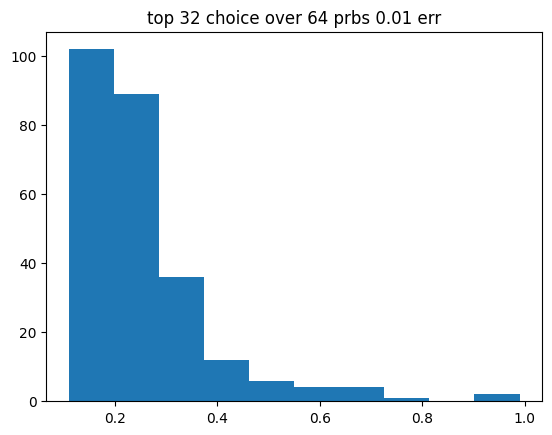

In [ ]:
plt.hist(rmse)
plt.title('top 32 choice over 64 prbs 0.01 err')


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on prbs input 0.01 err {rmse.mean()}")

rmse rand 32 over 64 on prbs input 0.01 err 0.27597278356552124


Text(0.5, 1.0, 'random 32 choice over 64 prbs 0.01 err')

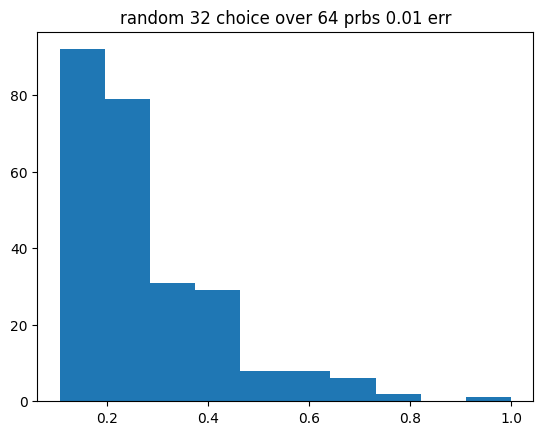

In [ ]:
plt.hist(rmse)
plt.title('random 32 choice over 64 prbs 0.01 err')


# PRBS 0.1 err


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse top 32 over 64 on prbs input 0.1 err {rmse.mean()}")

rmse top 32 over 64 on prbs input 0.1 err 0.2550082206726074


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse paper top 32 over 64 on prbs input 0.1 err {rmse.mean()}")

rmse paper top 32 over 64 on prbs input 0.01 err 0.21055008471012115


Text(0.5, 1.0, 'top 32 choice over 64 prbs 0.01 err')

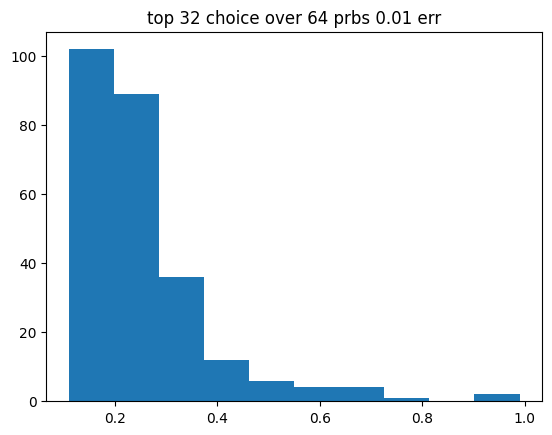

In [ ]:
plt.hist(rmse)
plt.title('top 32 choice over 64 prbs 0.1 err')


Text(0.5, 1.0, 'top paper 32 choice over 64 prbs 0.01 err')

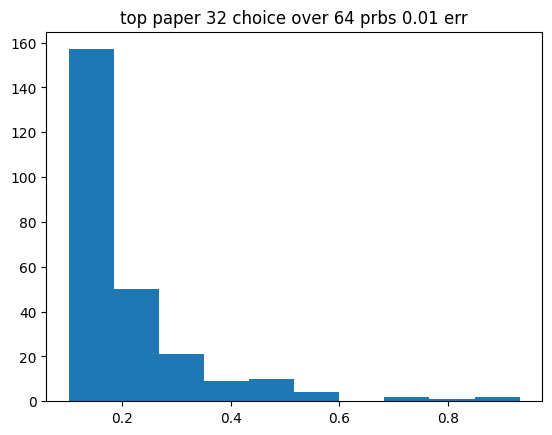

In [ ]:
plt.hist(rmse)
plt.title('top paper 32 choice over 64 prbs 0.1 err')


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on prbs input 0.1 err {rmse.mean()}")

rmse rand 32 over 64 on prbs input 0.1 err 0.24166667461395264


Text(0.5, 1.0, 'rand 32 choice over 64 prbs 0.1 err')

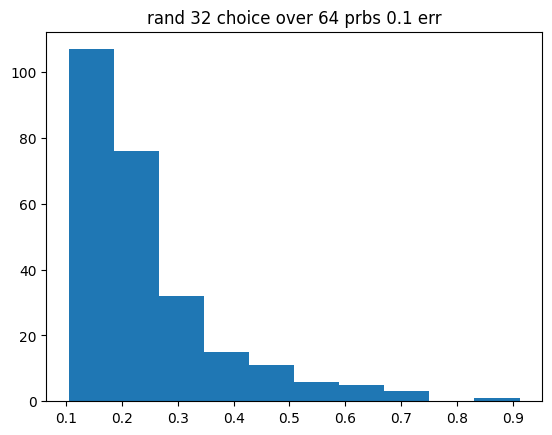

In [ ]:
plt.hist(rmse)
plt.title('rand 32 choice over 64 prbs 0.1 err')


## CSTR MULTISINE 0.01

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean[:,:,:], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean2[:,:,:], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(axis = 0),rmse2.mean(axis = 0)}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (array([0.10453648, 0.07854865, 0.14033604], dtype=float32), array([0.08071026, 0.0435149 , 0.14756788], dtype=float32))


In [ ]:
top = 800
indices_1 = torch.zeros([top,3])
indices_2 = torch.zeros([top,3])
for i in range(3):   
    _, indices_1[:,i] =torch.topk(torch.tensor(rmse[:,i]),k = top, largest = True)
    _, indices_2[:,i] =torch.topk(torch.tensor(rmse2[:,i]),k = top, largest = True)

In [ ]:
indices_1 = indices_1.int()
indices_2 = indices_2.int()

In [ ]:
rmse_1_0 = rmse[rmse[:,0] >= 0.6,0]
rmse2_1_0 = rmse2[rmse2[:,0] >= 0.6,0]
rmse_1_1 = rmse[rmse[:,1] >= 0.4,1]
rmse2_1_1 = rmse2[rmse2[:,1] >= 0.4,1]
rmse_1_2 = rmse[rmse[:,2] >= 0.4,2]
rmse2_1_2 = rmse2[rmse2[:,2] >= 0.4,2]

In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:80,0],0].mean(),rmse[indices_1[:80,1],1].mean(),rmse[indices_1[:80,2],2].mean()}{rmse2[indices_2[:80,0],0].mean(),rmse2[indices_2[:80,1],1].mean(),rmse2[indices_2[:80,2],2].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.4293522, 0.259498, 0.52798814)(0.48673254, 0.32009122, 0.59099066)


Text(0.5, 0.98, 'Comparison between classic and robust training CSTR multisine')

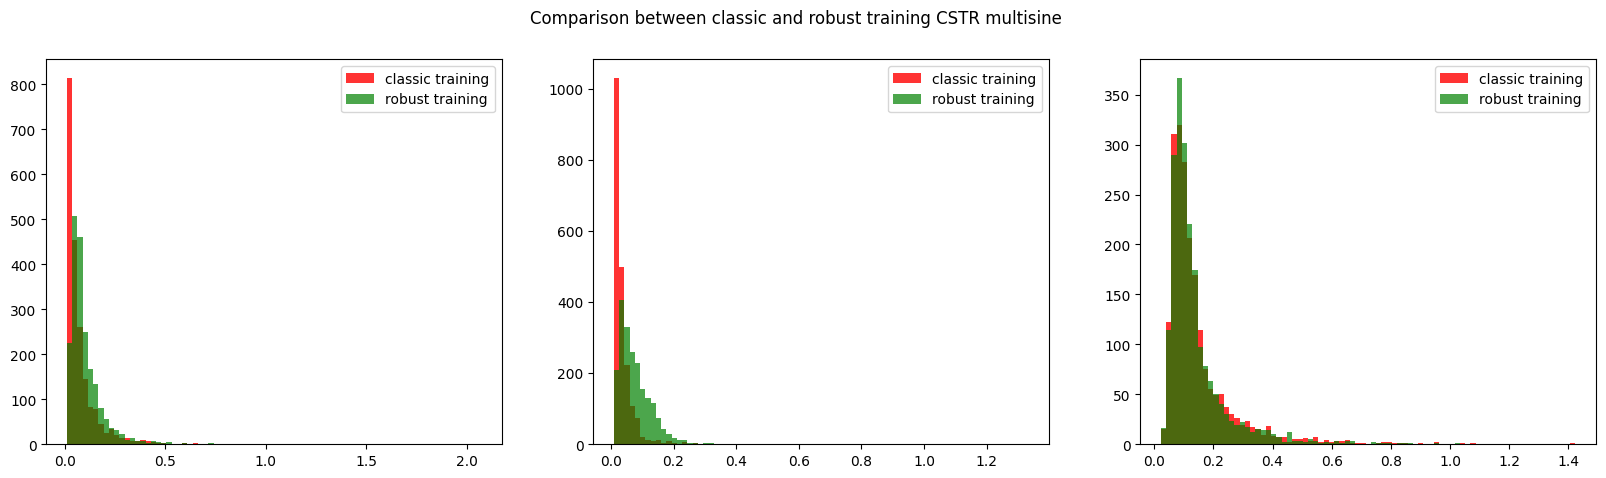

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])
for i in range(3):
    min_edge = min(rmse2[:,i].min(), rmse[:,i].min())
    max_edge = max(rmse2[:,i].max(), rmse[:,i].max())
    bins = np.linspace(min_edge, max_edge, 80)
    ax[i].hist(rmse2[:,i], bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
    ax[i].hist(rmse[:,i],  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

    ax[i].legend()
plt.suptitle('Comparison between classic and robust training CSTR multisine')

Text(0.5, 0.98, 'Comparison between classic and robust training CSTR prbs')

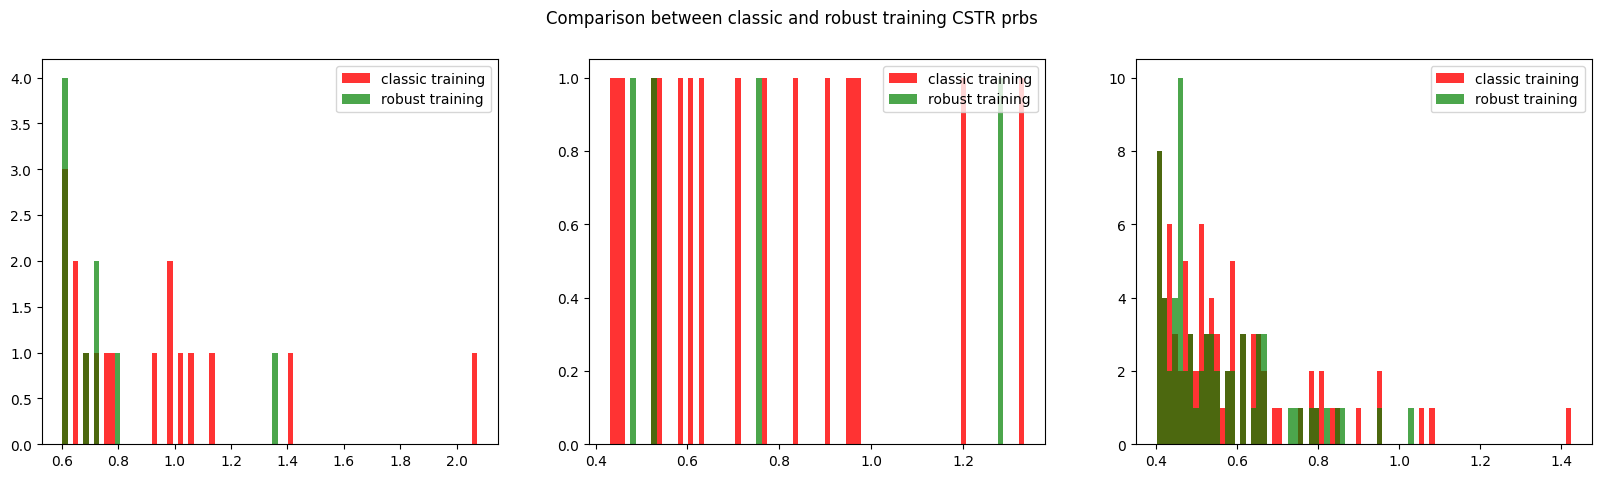

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])

min_edge = min(rmse2_1_0.min(), rmse_1_0.min())
max_edge = max(rmse2_1_0.max(), rmse_1_0.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[0].hist(rmse2_1_0, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[0].hist(rmse_1_0,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[0].legend()

min_edge = min(rmse2_1_1.min(), rmse_1_1.min())
max_edge = max(rmse2_1_1.max(), rmse_1_1.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[1].hist(rmse2_1_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[1].hist(rmse_1_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[1].legend()

min_edge = min(rmse2_1_2.min(), rmse_1_2.min())
max_edge = max(rmse2_1_2.max(), rmse_1_2.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[2].hist(rmse2_1_2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[2].hist(rmse_1_2,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[2].legend()

plt.suptitle('Comparison between classic and robust training CSTR prbs')

## CSTR PRBS 0.01

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean[:,:,:], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean2[:,:,:], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(axis = 0),rmse2.mean(axis = 0)}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (array([0.31346628, 0.18344761, 0.22530045], dtype=float32), array([0.33209258, 0.17463958, 0.21937722], dtype=float32))


In [ ]:
top = 800
indices_1 = torch.zeros([top,3])
indices_2 = torch.zeros([top,3])
for i in range(3):   
    _, indices_1[:,i] =torch.topk(torch.tensor(rmse[:,i]),k = top, largest = True)
    _, indices_2[:,i] =torch.topk(torch.tensor(rmse2[:,i]),k = top, largest = True)

In [ ]:
indices_1 = indices_1.int()
indices_2 = indices_2.int()

In [ ]:
rmse_1_0 = rmse[rmse[:,0] >= 0.6,0]
rmse2_1_0 = rmse2[rmse2[:,0] >= 0.6,0]
rmse_1_1 = rmse[rmse[:,1] >= 0.4,1]
rmse2_1_1 = rmse2[rmse2[:,1] >= 0.4,1]
rmse_1_2 = rmse[rmse[:,2] >= 0.4,2]
rmse2_1_2 = rmse2[rmse2[:,2] >= 0.4,2]

In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:80,0],0].mean(),rmse[indices_1[:80,1],1].mean(),rmse[indices_1[:80,2],2].mean()}{rmse2[indices_2[:80,0],0].mean(),rmse2[indices_2[:80,1],1].mean(),rmse2[indices_2[:80,2],2].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.76063144, 0.4903737, 0.5000187)(0.7966233, 0.5599188, 0.54463035)


Text(0.5, 0.98, 'Comparison between classic and robust training CSTR prbs')

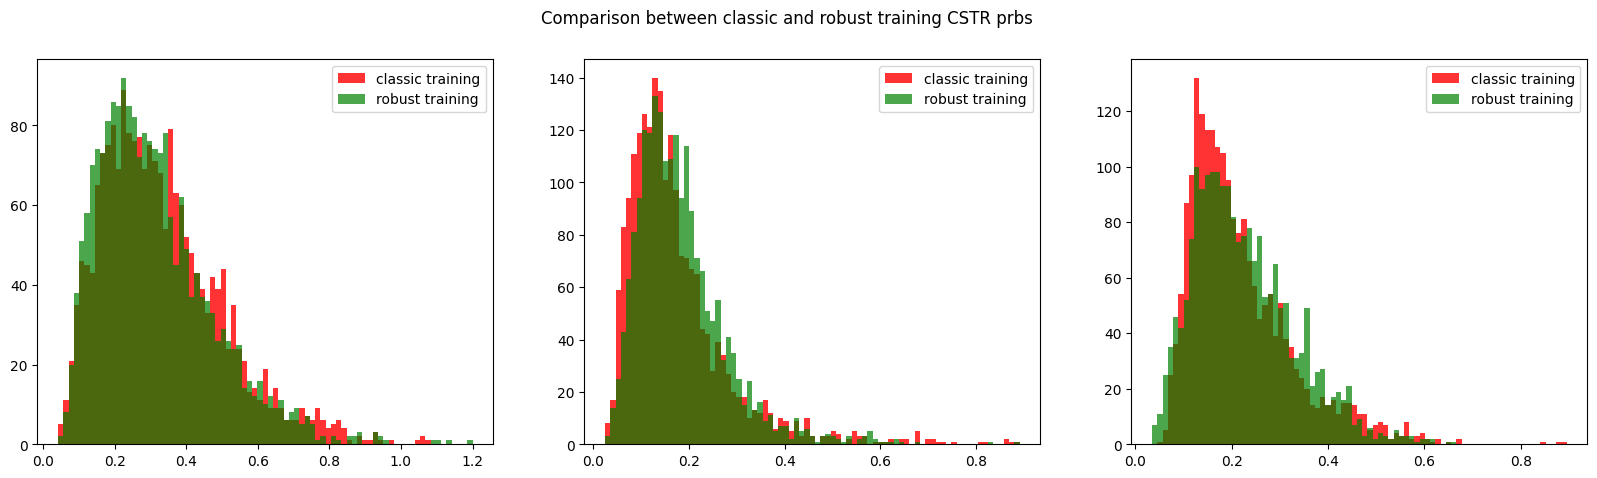

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])
for i in range(3):
    min_edge = min(rmse2[:,i].min(), rmse[:,i].min())
    max_edge = max(rmse2[:,i].max(), rmse[:,i].max())
    bins = np.linspace(min_edge, max_edge, 80)
    ax[i].hist(rmse2[:,i], bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
    ax[i].hist(rmse[:,i],  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

    ax[i].legend()
plt.suptitle('Comparison between classic and robust training CSTR prbs')

Text(0.5, 0.98, 'Comparison between classic and robust training CSTR prbs')

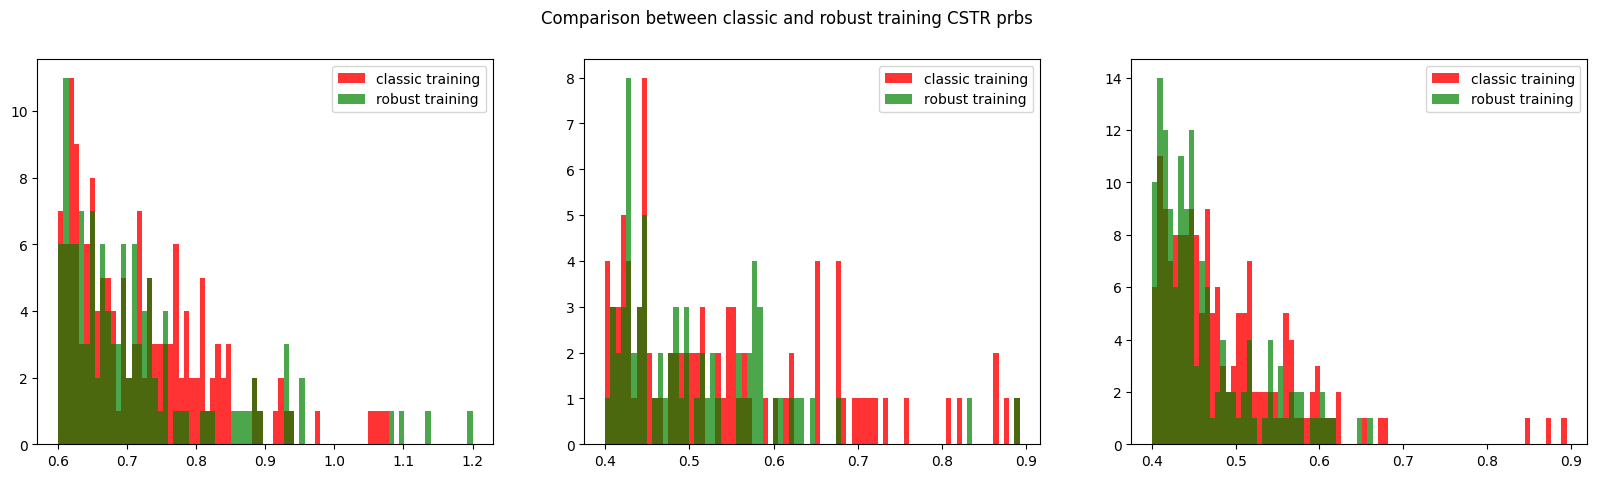

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])

min_edge = min(rmse2_1_0.min(), rmse_1_0.min())
max_edge = max(rmse2_1_0.max(), rmse_1_0.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[0].hist(rmse2_1_0, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[0].hist(rmse_1_0,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[0].legend()

min_edge = min(rmse2_1_1.min(), rmse_1_1.min())
max_edge = max(rmse2_1_1.max(), rmse_1_1.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[1].hist(rmse2_1_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[1].hist(rmse_1_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[1].legend()

min_edge = min(rmse2_1_2.min(), rmse_1_2.min())
max_edge = max(rmse2_1_2.max(), rmse_1_2.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[2].hist(rmse2_1_2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[2].hist(rmse_1_2,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[2].legend()

plt.suptitle('Comparison between classic and robust training CSTR prbs')

## CSTR WHITE NOISE 0.01

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean[:,:,:], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, :], batch_y_mean2[:,:,:], time_axis=1)
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse.mean(axis = 0),rmse2.mean(axis = 0)}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (array([0.10746957, 0.05662626, 0.11084801], dtype=float32), array([0.07337329, 0.03532438, 0.1295675 ], dtype=float32))


In [ ]:
top = 80
indices_1 = torch.zeros([top,3])
indices_2 = torch.zeros([top,3])
for i in range(3):   
    _, indices_1[:,i] =torch.topk(torch.tensor(rmse[:,i]),k = top, largest = True)
    _, indices_2[:,i] =torch.topk(torch.tensor(rmse2[:,i]),k = top, largest = True)

In [ ]:
rmse_1_0 = rmse[rmse[:,0] >= 0.15,0]
rmse2_1_0 = rmse2[rmse2[:,0] >= 0.15,0]
rmse_1_1 = rmse[rmse[:,1] >= 0.15,1]
rmse2_1_1 = rmse2[rmse2[:,1] >= 0.15,1]
rmse_1_2 = rmse[rmse[:,2] >= 0.15,2]
rmse2_1_2 = rmse2[rmse2[:,2] >= 0.15,2]

In [ ]:
indices_1 = indices_1.int()
indices_2 = indices_2.int()

In [ ]:
print(f"rmse paper top 32 over 64 on whitenoise input 0.01 err {rmse[indices_1[:80,0],0].mean(),rmse[indices_1[:80,1],1].mean(),rmse[indices_1[:80,2],2].mean()}{rmse2[indices_2[:80,0],0].mean(),rmse2[indices_2[:80,1],1].mean(),rmse2[indices_2[:80,2],2].mean()}")

rmse paper top 32 over 64 on whitenoise input 0.01 err (0.3693939, 0.1859897, 0.31188187)(0.3734916, 0.12706259, 0.38618112)


Text(0.5, 0.98, 'Comparison between classic and robust training CSTR prbs')

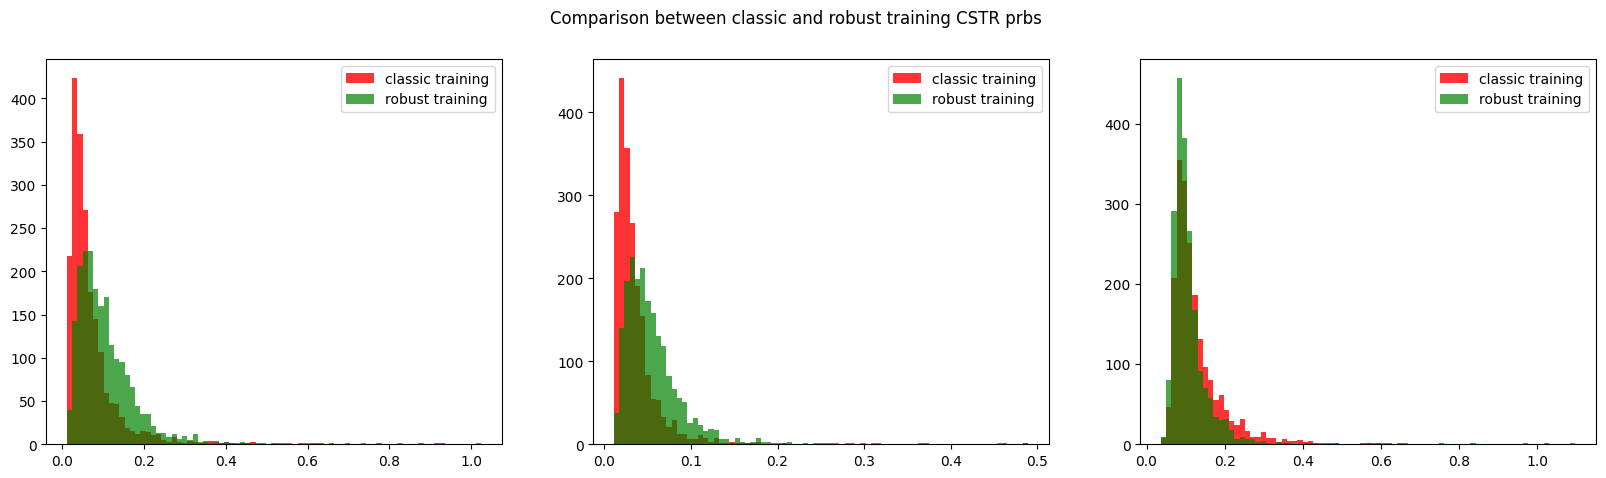

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])
for i in range(3):
    min_edge = min(rmse2[:,i].min(), rmse[:,i].min())
    max_edge = max(rmse2[:,i].max(), rmse[:,i].max())
    bins = np.linspace(min_edge, max_edge, 80)
    ax[i].hist(rmse2[:,i], bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
    ax[i].hist(rmse[:,i],  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

    ax[i].legend()
plt.suptitle('Comparison between classic and robust training CSTR prbs')

NameError: name 'rmse2_1' is not defined

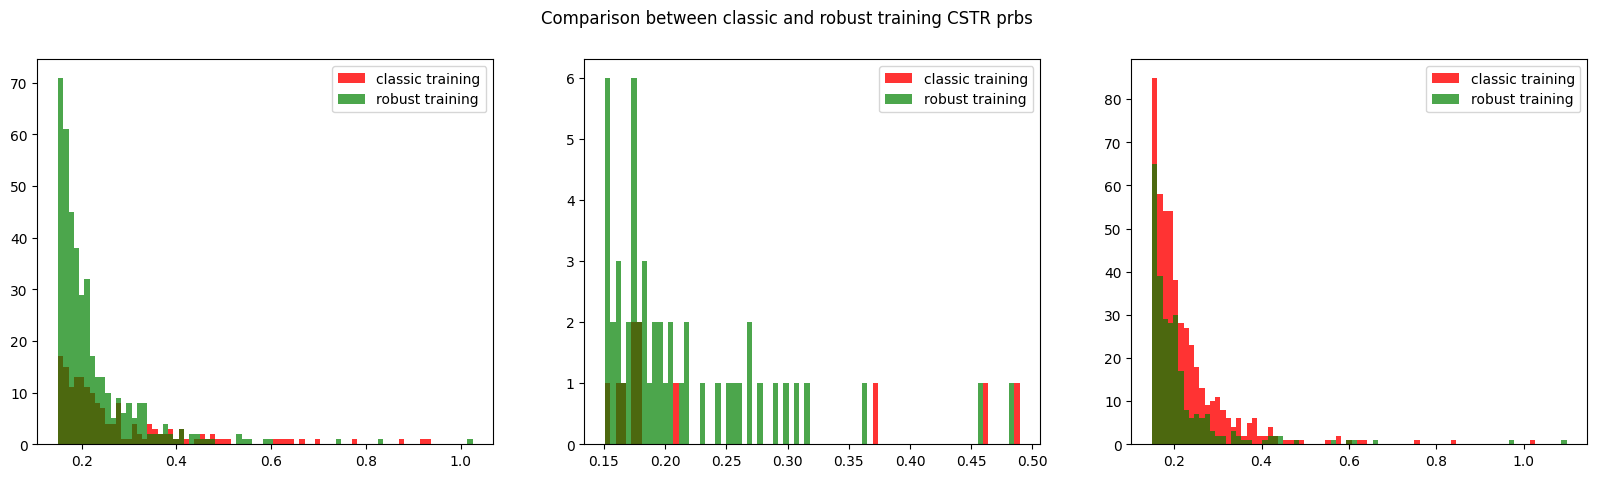

In [ ]:
fig,ax = plt.subplots(1,3, figsize = [20,5])

min_edge = min(rmse2_1_0.min(), rmse_1_0.min())
max_edge = max(rmse2_1_0.max(), rmse_1_0.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[0].hist(rmse2_1_0, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[0].hist(rmse_1_0,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[0].legend()

min_edge = min(rmse2_1_1.min(), rmse_1_1.min())
max_edge = max(rmse2_1_1.max(), rmse_1_1.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[1].hist(rmse2_1_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[1].hist(rmse_1_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[1].legend()

min_edge = min(rmse2_1_2.min(), rmse_1_2.min())
max_edge = max(rmse2_1_2.max(), rmse_1_2.max())
bins = np.linspace(min_edge, max_edge, 80)
ax[2].hist(rmse2_1_2, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
ax[2].hist(rmse_1_2,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')
ax[2].legend()

plt.suptitle('Comparison between classic and robust training CSTR prbs')
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')

Text(0.5, 1.0, 'top 32 choice over 64 on CSTR system ')

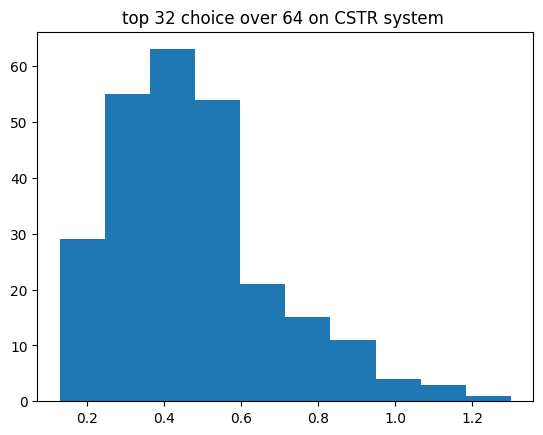

In [ ]:
plt.hist(rmse)
plt.title('top 32 choice over 64 on CSTR system ')


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on prbs input checkpoint {rmse.mean()}")

rmse rand 32 over 64 on prbs input checkpoint 0.30260422825813293


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse rand 32 over 64 on prbs input 0.1 err {rmse.mean()}")

rmse rand 32 over 64 on prbs input 0.1 err 0.2495172619819641


Text(0.5, 1.0, 'rand 32 choice over 64 prbs 0.1 err')

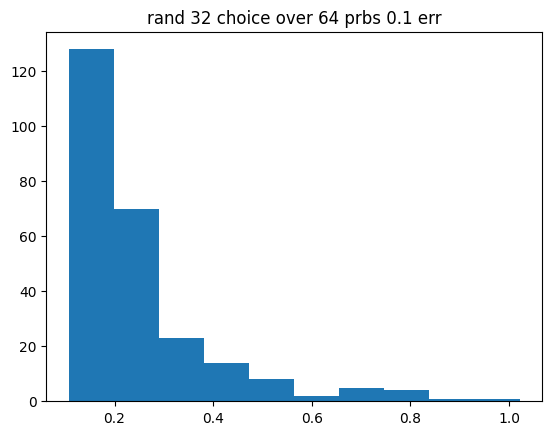

In [ ]:
plt.hist(rmse)
plt.title('rand 32 choice over 64 prbs 0.1 err')


(array([140.,  69.,  21.,  11.,   7.,   2.,   1.,   3.,   1.,   1.]),
 array([0.02130244, 0.13393858, 0.24657471, 0.35921085, 0.471847  ,
        0.58448315, 0.6971193 , 0.80975538, 0.92239153, 1.03502774,
        1.14766383]),
 <BarContainer object of 10 artists>)

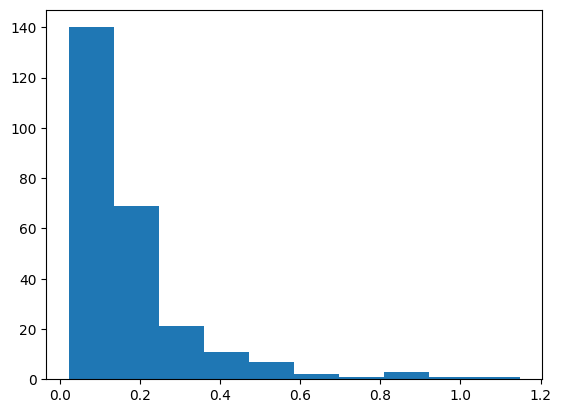

In [ ]:
plt.hist(rmse)

In [ ]:
_, indices_2 = torch.topk(torch.exp(-nll).mean(axis = 1).view(-1),k = 256, largest = False)
_, indices= torch.topk(torch.tensor(rmse),k = 256, largest = True)


In [ ]:
print(f"worst indices WN {indices[:10], indices_2[:10]}")

worst indices WN (tensor([216, 194,  81,  36,  76, 173, 204,  20, 196,  77]), tensor([216,  76, 196, 194, 204,  36, 173,  77,  81, 158]))


In [ ]:
print(f"worst indices prbs{indices[:10], indices_2[:10]}")

worst indices prbs(tensor([ 53, 196, 167, 186,   8, 152, 129,  81,  36, 206]), tensor([167, 196,  36, 164,   8, 125, 170, 102,  81,  77]))


In [ ]:
torch.exp(-nll).mean(axis = 1)[indices[:10]]

tensor([[1.4182],
        [0.4971],
        [0.4045],
        [1.2758],
        [0.5234],
        [0.6318],
        [1.4187],
        [0.5475],
        [0.5034],
        [0.9680]])

In [ ]:
torch.exp(-nll).mean(axis = 1)[indices_2]

tensor([[0.3618],
        [0.7116],
        [0.7172],
        [0.7213],
        [0.7712],
        [0.7844],
        [0.7963],
        [0.9212],
        [0.9271],
        [1.0146],
        [1.0206],
        [1.0209],
        [1.0273],
        [1.0477],
        [1.0748],
        [1.1182],
        [1.1272],
        [1.1347],
        [1.1452],
        [1.1514],
        [1.1572],
        [1.1816],
        [1.1874],
        [1.1877],
        [1.2066],
        [1.2466],
        [1.2506],
        [1.2631],
        [1.3114],
        [1.3168],
        [1.3492],
        [1.3582],
        [1.4468],
        [1.4582],
        [1.4634],
        [1.4768],
        [1.4959],
        [1.5000],
        [1.5156],
        [1.5228],
        [1.5247],
        [1.5258],
        [1.5388],
        [1.5467],
        [1.5476],
        [1.5636],
        [1.5767],
        [1.6106],
        [1.6218],
        [1.6362],
        [1.6475],
        [1.7027],
        [1.7038],
        [1.7203],
        [1.7320],
        [1

In [ ]:
rmse[indices_2[:10]]


array([0.72457963, 0.44937205, 0.355986  , 0.5544312 , 0.37958178,
       0.46730292, 0.3953339 , 0.33450523, 0.5329426 , 0.32123148],
      dtype=float32)

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on binary input {rmse.mean()}")

rmse over the 400 ctx on binary input 0.2592735290527344


In [ ]:
batch_u_1.shape

NameError: name 'batch_u_1' is not defined

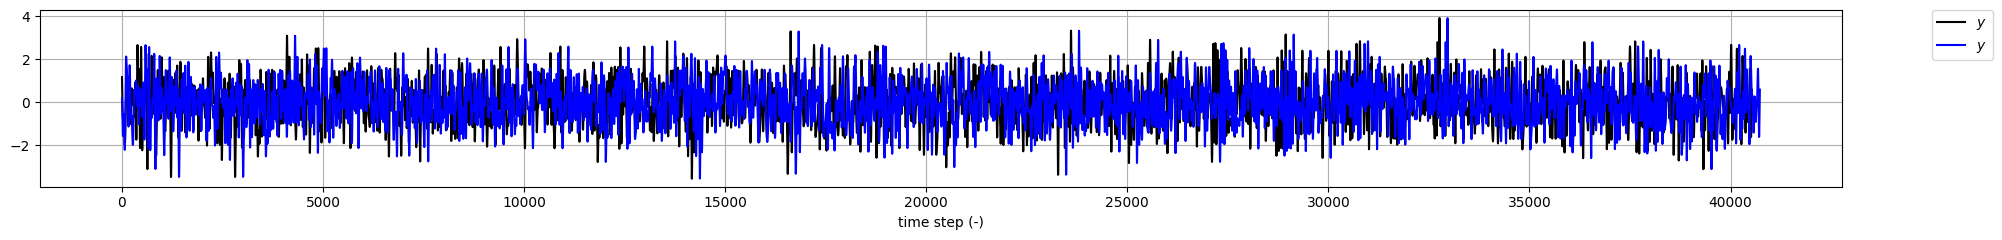

In [ ]:
plt.figure(figsize=(20, 2.5))
idx = 0
plt.plot(np.arange(batch_u.shape[1]), batch_u[0,:,0], 'k', label="$y$")
plt.plot(np.arange(batch_u_1.shape[1]), batch_u_1[0,:], 'b', label="$y$")
# plt.plot(t, batch_whitenoise[idx, 1000+cfg.seq_len_n_in:, :], 'b', label="$y$")
# plt.plot(t, batch_y_new[idx, :, :], 'k', label="$y$")
# plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
# plt.fill_between(x=t, y1=batch_y_minus[idx,:,  0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single.pdf")

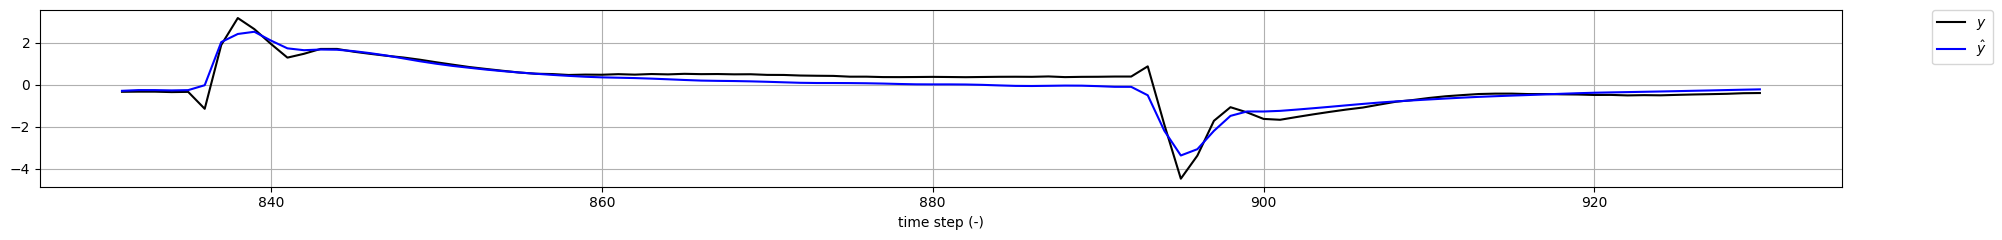

In [ ]:
plt.figure(figsize=(20, 2.5))
idx = 0
# plt.plot(np.arange(500), batch_u[0,:500,0], 'k', label="$y$")
# plt.plot(np.arange(batch_u_1.shape[1]), batch_u_1[0,:], 'b', label="$y$")
# plt.plot(t, batch_whitenoise[idx, 1000+cfg.seq_len_n_in:, :], 'b', label="$y$")
plt.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label="$y$")
plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
# plt.fill_between(x=t, y1=batch_y_minus[idx,:,  0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single.pdf")

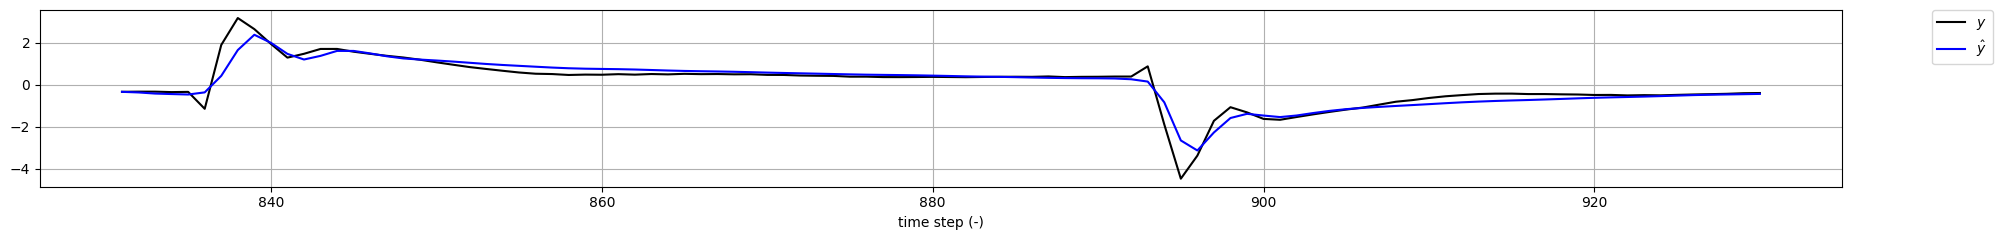

In [ ]:
plt.figure(figsize=(20, 2.5))
idx = 0
# plt.plot(np.arange(500), batch_u[0,:500,0], 'k', label="$y$")
# plt.plot(np.arange(batch_u_1.shape[1]), batch_u_1[0,:], 'b', label="$y$")
# plt.plot(t, batch_whitenoise[idx, 1000+cfg.seq_len_n_in:, :], 'b', label="$y$")
plt.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label="$y$")
plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
# plt.fill_between(x=t, y1=batch_y_minus[idx,:,  0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single.pdf")

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 40k ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 40k ctx mutlisines with f under 0.15 0.3968260586261749


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 16k ctx mutlisines with f under 0.15 0.37856778502464294


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 4k ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 4k ctx mutlisines with f under 0.15 0.36622878909111023


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 800 patch ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 800 patch ctx mutlisines with f under 0.15 0.7724611759185791


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 400 ctx mutlisines with f under 0.15 0.6100095510482788


IndexError: index 1 is out of bounds for axis 2 with size 1

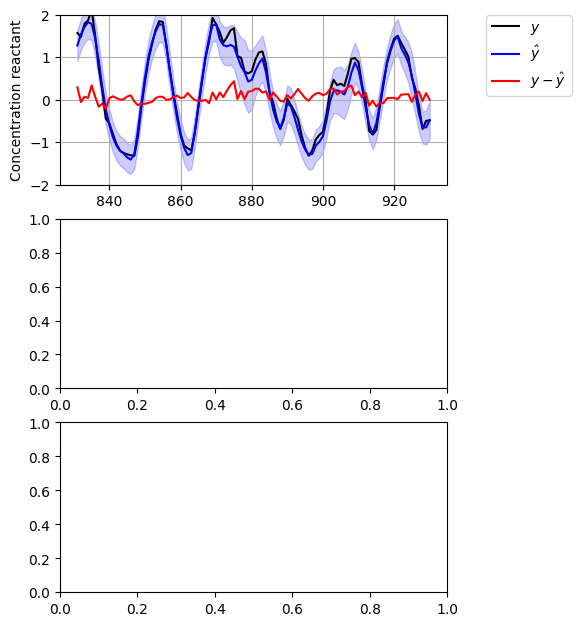

In [ ]:
#plot of the last batch

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5, 7.5))
#plt.figure(figsize=(5, 2.5))
idx =  10
ax1.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 0], 'k', label="$y$")
ax1.plot(t, batch_y_mean[idx, :, 0], 'b', label="$\\hat y$")
ax1.fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax1.plot(t, batch_sim_err[idx, :, 0], 'r', label="$y - \\hat y$")
ax1.grid(True)
ax1.set_ylabel("Concentration reactant")
ax1.set_ylim([-2,2])
ax1.legend(bbox_to_anchor=(1.1, 1),loc = 2, borderaxespad=0.)

ax2.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 1], 'k', label="$y$")
ax2.plot(t, batch_y_mean[idx, :, 1], 'b', label="$\\hat y$")
ax2.fill_between(x=t, y1=batch_y_minus[idx, :,1], y2=batch_y_plus[idx, :, 1], color="blue", alpha=0.2)
ax2.plot(t, batch_sim_err[idx, :, 1], 'r', label="$y - \\hat y$")
ax2.grid(True)
ax2.set_ylabel("Temperature reactor")
ax2.set_ylim([-2,2])
ax2.legend(bbox_to_anchor=(1.05, 1),loc = 2, borderaxespad=0.)

ax3.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 2], 'k', label="$y$")
ax3.plot(t, batch_y_mean[idx, :, 2], 'b', label="$\\hat y$")
ax3.fill_between(x=t, y1=batch_y_minus[idx, :, 2], y2=batch_y_plus[idx, :, 2], color="blue", alpha=0.2)
ax3.plot(t, batch_sim_err[idx, :, 2], 'r', label="$y - \\hat y$")
ax3.grid(True)
ax3.set_ylabel("Temperature jacket")
ax3.set_ylim([-2,2])
ax3.set_xlabel("time step (-)")
ax3.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.tight_layout()
#plt.savefig(fig_path / "CSTR_sim_single_last.pdf")

In [ ]:
#plot of the last batch

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5, 7.5))
#plt.figure(figsize=(5, 2.5))
idx =  10
ax1.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 0], 'k', label="$y$")
ax1.plot(t, batch_y_mean[idx, :, 0], 'b', label="$\\hat y$")
ax1.fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax1.plot(t, batch_sim_err[idx, :, 0], 'r', label="$y - \\hat y$")
ax1.grid(True)
ax1.set_ylabel("Concentration reactant")
ax1.set_ylim([-2,2])
ax1.legend(bbox_to_anchor=(1.1, 1),loc = 2, borderaxespad=0.)

ax2.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 1], 'k', label="$y$")
ax2.plot(t, batch_y_mean[idx, :, 1], 'b', label="$\\hat y$")
ax2.fill_between(x=t, y1=batch_y_minus[idx, :,1], y2=batch_y_plus[idx, :, 1], color="blue", alpha=0.2)
ax2.plot(t, batch_sim_err[idx, :, 1], 'r', label="$y - \\hat y$")
ax2.grid(True)
ax2.set_ylabel("Temperature reactor")
ax2.set_ylim([-2,2])
ax2.legend(bbox_to_anchor=(1.05, 1),loc = 2, borderaxespad=0.)

ax3.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, 2], 'k', label="$y$")
ax3.plot(t, batch_y_mean[idx, :, 2], 'b', label="$\\hat y$")
ax3.fill_between(x=t, y1=batch_y_minus[idx, :, 2], y2=batch_y_plus[idx, :, 2], color="blue", alpha=0.2)
ax3.plot(t, batch_sim_err[idx, :, 2], 'r', label="$y - \\hat y$")
ax3.grid(True)
ax3.set_ylabel("Temperature jacket")
ax3.set_ylim([-2,2])
ax3.set_xlabel("time step (-)")
ax3.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.tight_layout()
#plt.savefig(fig_path / "CSTR_sim_single_last.pdf")

In [ ]:
# plot of the error in the test of the whole batch
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5, 7.5))
#plt.ylim([-3, 3])]
ax1.plot(t, batch_y_new[:,cfg.seq_len_n_in:,0].T, "k", alpha=0.5);
ax1.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax1.plot(t, batch_sim_err[:, :, 0].T, "r", alpha=0.2);
ax1.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax1.grid(True)
ax1.set_ylabel("Concentration reactant")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.plot(t, batch_y_new[:,cfg.seq_len_n_in:,1].T, "k", alpha=0.5);
ax2.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax2.plot(t, batch_sim_err[:, :, 1].T, "r", alpha=0.2);
ax2.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax2.grid(True)
ax2.set_ylabel("Temperature reactor")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.plot(t, batch_y_new[:,cfg.seq_len_n_in:,2].T, "k", alpha=0.5);
ax3.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax3.plot(t, batch_sim_err[:, :, 2].T, "r", alpha=0.2);
ax3.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax3.grid(True)
ax3.set_ylabel("Temperature jacket")
ax3.set_xlabel("time step (-)")
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
#plt.savefig(fig_path / "CSTR_sim_batch_last.pdf")

In [ ]:
# plot of the error in the test of the whole batch
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5, 7.5))
#plt.ylim([-3, 3])]
ax1.plot(t, batch_y_new[:,cfg.seq_len_n_in:,0].T, "k", alpha=0.5);
ax1.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax1.plot(t, batch_sim_err[:, :, 0].T, "r", alpha=0.2);
ax1.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax1.grid(True)
ax1.set_ylabel("Concentration reactant")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.plot(t, batch_y_new[:,cfg.seq_len_n_in:,1].T, "k", alpha=0.5);
ax2.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax2.plot(t, batch_sim_err[:, :, 1].T, "r", alpha=0.2);
ax2.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax2.grid(True)
ax2.set_ylabel("Temperature reactor")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.plot(t, batch_y_new[:,cfg.seq_len_n_in:,2].T, "k", alpha=0.5);
ax3.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax3.plot(t, batch_sim_err[:, :, 2].T, "r", alpha=0.2);
ax3.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \\hat y$");
ax3.grid(True)
ax3.set_ylabel("Temperature jacket")
ax3.set_xlabel("time step (-)")
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
#plt.savefig(fig_path / "CSTR_sim_batch_last.pdf")

In [ ]:
plt.figure(figsize=(5, 2.5))
idx = 12
plt.plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label="$y$")
plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
plt.fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_single_8000ctx_64patched.pdf")

IndexError: index 20 is out of bounds for dimension 0 with size 1

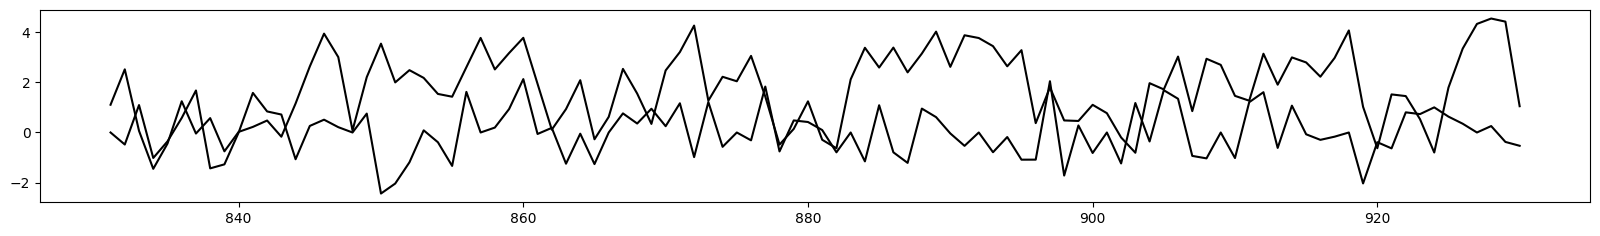

In [ ]:
plt.figure(figsize=(20, 2.5))
idx = 20
plt.plot(t, batch_y_new[0, cfg.seq_len_n_in:, :], 'k', label="$y$")
plt.plot(t, batch_u_new[0, cfg.seq_len_n_in:, :], 'k', label="$y$")
# plt.plot(t, batch_y_new[idx, :, :], 'k', label="$y$")
plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
plt.fill_between(x=t, y1=batch_y_minus[idx,:,  0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_single.pdf")

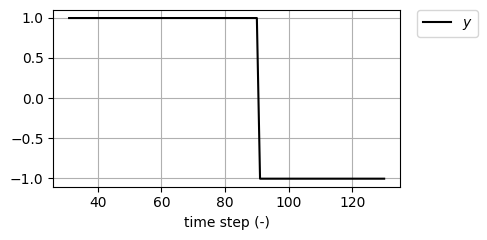

In [ ]:
plt.figure(figsize=(5, 2.5))
idx = 20
plt.plot(t, batch_u_new[idx, cfg.seq_len_n_in:, :], 'k', label="$y$")
# plt.plot(t, batch_y_mean[idx, :, :], 'b', label="$\hat y$")
# plt.fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# plt.plot(t, batch_sim_err[idx, :, :], 'r', label="$y - \hat y$")
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_batch_8000ctx_64patched.pdf")

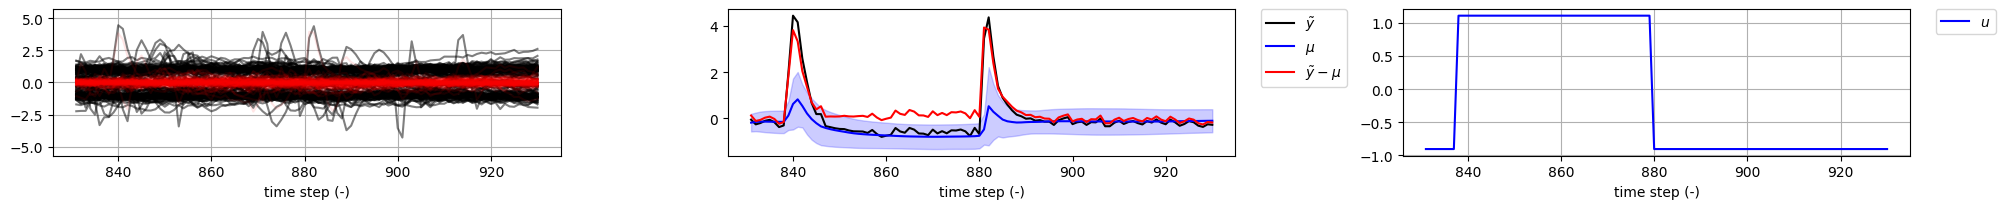

In [ ]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 53
fix, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx, :, :], 'b', label="$\mu$")
ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# ax[2].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[2].plot(t, batch_u[idx, -100:, :], 'b', label="$u$")
# ax[2].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# ax[2].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[2].set_xlabel("time step (-)")
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

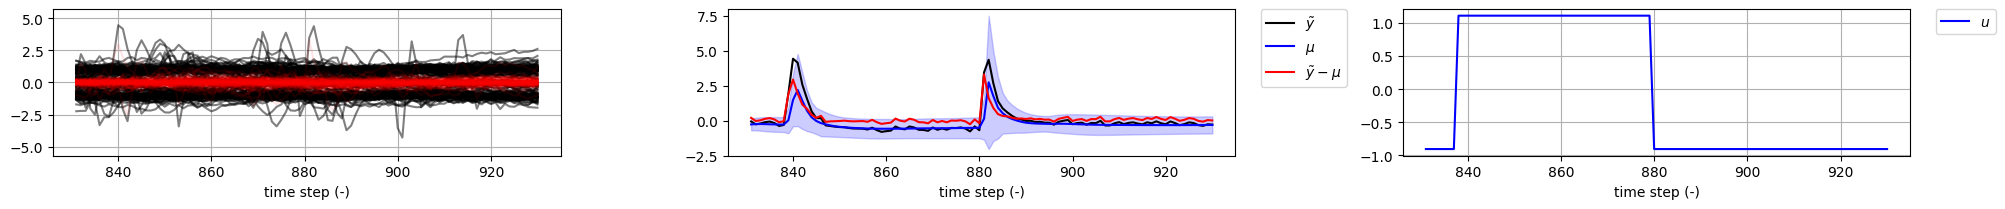

In [ ]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 53
fix, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx, :, :], 'b', label="$\mu$")
ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# ax[2].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[2].plot(t, batch_u[idx, -100:, :], 'b', label="$u$")
# ax[2].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# ax[2].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[2].set_xlabel("time step (-)")
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

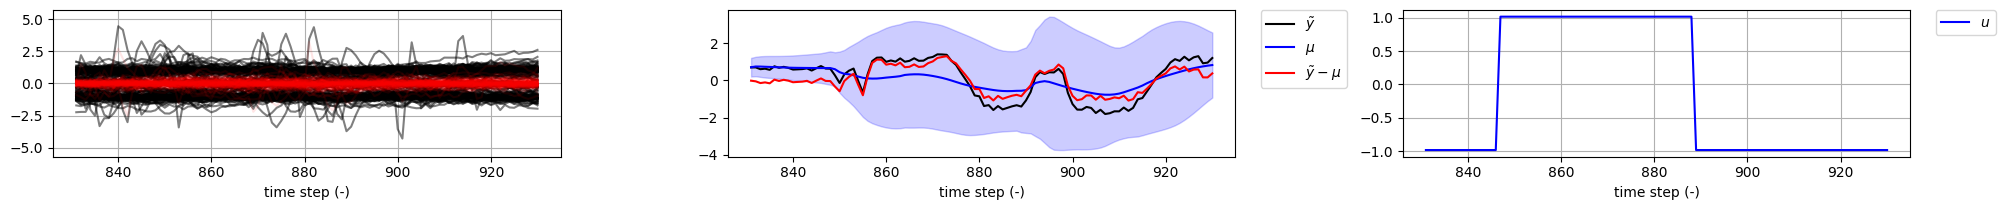

In [ ]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 81
fix, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx, :, :], 'b', label="$\mu$")
ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# ax[2].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[2].plot(t, batch_u[idx, -100:, :], 'b', label="$u$")
# ax[2].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
# ax[2].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[2].set_xlabel("time step (-)")
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

ValueError: x and y must have same first dimension, but have shapes (125,) and (100, 100)

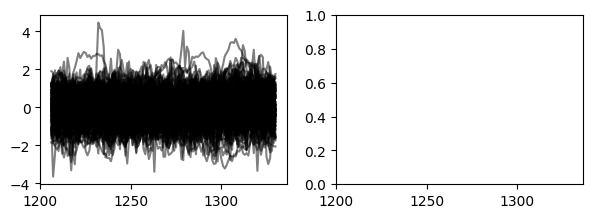

In [ ]:
idx = 15
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(7, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_n_in:, :], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx, :, :], 'b', label="$\mu$")
ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)

rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.figure(figsize=(20,5))
x = np.arange(0, 1100, 100)
y = np.ones_like(x) * 0.2  # Create small lines

# Create a stem plot

plt.stem(rmse, label= 'iterative')
plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro')
plt.stem(x, y, linefmt='r-', markerfmt=' ', basefmt=" ")


NameError: name 'batch_y_new2' is not defined

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, -100:, 0], batch_y_mean[:,-100:,0], time_axis=1)
print(f"rmse predicting only the first iteratively {rmse.mean()}")

rmse predicting only the first iteratively 0.15174779295921326


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:cfg.seq_len_n_in+200, 0], batch_y_mean[:,:200,0], time_axis=1)
print(f"rmse predicting only the first iteratively {rmse.mean()}")

rmse predicting only the first iteratively 0.1495886594057083


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:130, 0], batch_y_mean[:,:100,0], time_axis=1)
print(f"rmse predicting only the first iteratively {rmse.mean()}")

rmse predicting only the first iteratively 0.17366360127925873


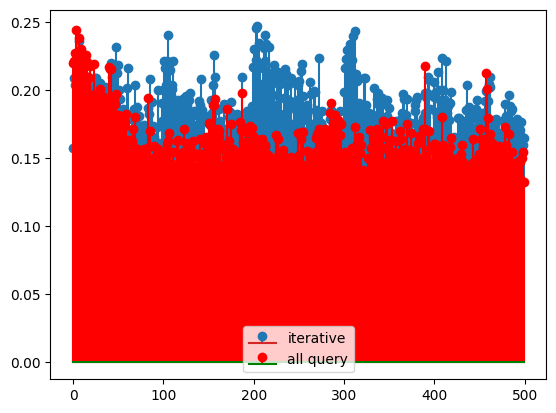

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.stem(rmse, label= 'iterative')
plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro')
plt.legend()

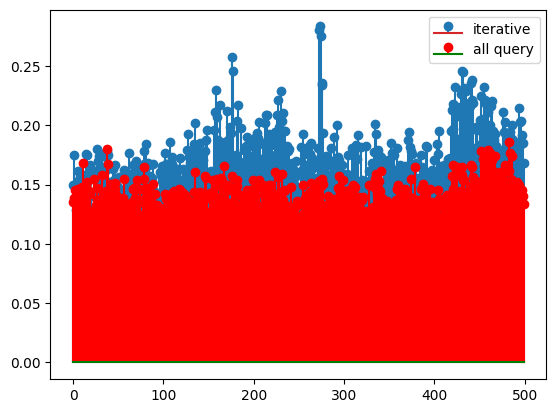

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.stem(rmse, label= 'iterative')
plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro', basefmt='g-')
plt.legend()

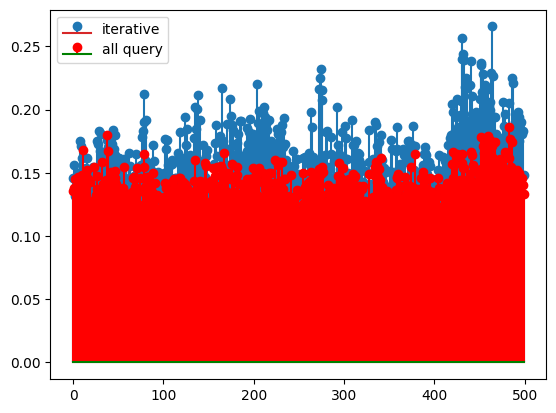

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.stem(rmse, label= 'iterative')
plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro', basefmt='g-')
plt.legend()

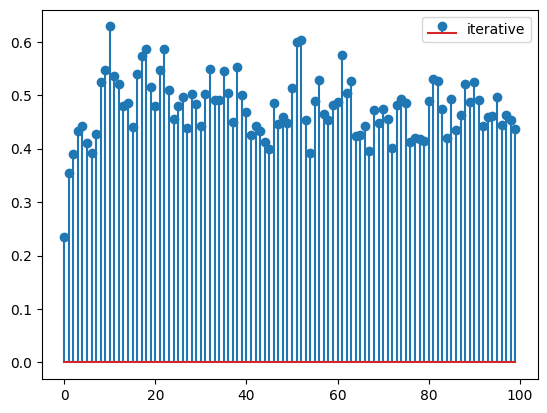

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
# rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.stem(rmse, label= 'iterative')
# plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro', basefmt='g-')
plt.legend()

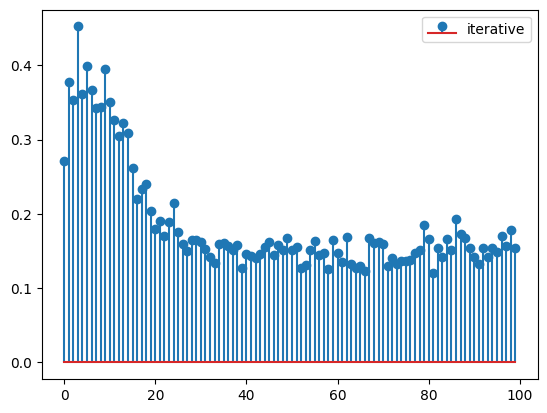

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=0)
# rmse2 = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=0)
plt.stem(rmse, label= 'iterative')
# plt.stem(rmse2, label= 'all query',linefmt='r-', markerfmt='ro', basefmt='g-')
plt.legend()

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse predicting all the query iteratively {rmse.mean()}")

rmse predicting all the query iteratively 0.1599033921957016


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse predicting all the query iteratively {rmse.mean()}")

rmse predicting all the query iteratively 0.153405100107193


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:cfg.seq_len_n_in+100, 0], batch_y_mean[:,:100,0], time_axis=1)
print(f"rmse predicting only the first iteratively {rmse.mean()}")

rmse predicting only the first iteratively 0.1483873575925827


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:cfg.seq_len_n_in+100, 0], batch_y_mean[:,:100,0], time_axis=1)
print(f"rmse predicting only the first iteratively {rmse.mean()}")

rmse predicting only the first iteratively 0.1483873575925827


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse predicting only the first all together {rmse.mean()}")

rmse predicting only the first all together 0.13623565435409546


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new2[:, cfg.seq_len_n_in:cfg.seq_len_n_in+100, 0], batch_y_mean2[:,0:100,0], time_axis=1)
print(f"rmse predicting only the first all query together {rmse.mean()}")

rmse predicting only the first all query together 0.13657516241073608


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse predicting all the query iteratively {rmse.mean()}")

rmse predicting all the query iteratively 0.16656917333602905


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 40k ctx on binary input {rmse.mean()}")

rmse over the 40k ctx on binary input 0.47952401638031006


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx on binary input {rmse.mean()}")

rmse over the 16k ctx on binary input 0.30703967809677124


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 4k ctx on binary input {rmse.mean()}")

rmse over the 4k ctx on binary input 0.24936151504516602


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on binary input {rmse.mean()}")

rmse over the 400 ctx on binary input 0.23580656945705414


In [ ]:
np.argmax(rmse)

8

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on binary input {rmse.mean()}")

rmse over the 400 ctx on binary input 0.1470198780298233


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on binary input {rmse.mean()}")

rmse over the 400 ctx on binary input 0.15644749999046326


In [ ]:
np.argmax(rmse)


81

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 40k ctx on mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 40k ctx on mutlisines 0.7338073253631592


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 16k ctx mutlisines with f under 0.15 0.5035743713378906


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx mutlisines with f under 0.15 {rmse.mean()}")

rmse over the 16k ctx mutlisines with f under 0.15 0.5321527719497681


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 4k ctx on multisines  {rmse.mean()}")

rmse over the 4k ctx on multisines  0.32768356800079346


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on multisines  {rmse.mean()}")

rmse over the 400 ctx on multisines  0.17980754375457764


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on multisines  {rmse.mean()}")

rmse over the 400 ctx on multisines  0.15509989857673645


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 40k ctx on mutlisines with f under 0.40 {rmse.mean()}")

rmse over the 40k ctx on mutlisines with f under 0.40 0.12004492431879044


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx mutlisines with f under 0.4 {rmse.mean()}")

rmse over the 16k ctx mutlisines with f under 0.4 0.13103659451007843


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 4k ctx on multisines with f under 0.40 {rmse.mean()}")

rmse over the 4k ctx on multisines with f under 0.40 0.411189466714859


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on multisines with f under 0.40 {rmse.mean()}")

rmse over the 400 ctx on multisines 0.1928015798330307


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 40k ctx on mutlisines with f under 0.30 {rmse.mean()}")

In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 16k ctx mutlisines with f under 0.30 {rmse.mean()}")

rmse over the 16k ctx mutlisines with f under 0.30 0.12683245539665222


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 4k ctx on multisines with f under 0.30 {rmse.mean()}")

rmse over the 4k ctx on multisines with f under 0.30 0.5820145606994629


In [ ]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
print(f"rmse over the 400 ctx on multisines with f under 0.30  {rmse.mean()}")

rmse over the 400 ctx on multisines over 39 frequencies 0.33396923542022705


In [ ]:
print(rmse_sorted, sort_std)

[201  45 132 159 198  80 240 232  21 142  24 120  74  66  46  54 111 185
 221  12 224 249 126  89  33  39 151 244  14 171 191 112  79 223 231  90
  26 153 115  92 247 110 236 255  48 229   6 197  63  68  25  84 104 130
 230  19  43  29 133  16 105 238  59 212 101  38 210   3 241 203  73  28
  22 207 117 248 166  57 215  34 219 211  86 182 114 218 136  67  62  49
 123 144  27 180 205 156 188 189 168 160  50 208 175 237  32  30  13 178
  98  96  99 150 161   0  78  53 234 202 177 176  47 108 222  42 190 225
 179 235  52 253  95  23  71   1   5 192  93 131 251  72 169 213 139 134
  76 107 141  69 140  37 158  40 128  15  91   2 109  56  41  44 100 246
  60 113  82 214 193 162  97 184 106  65 227  61  64 165 181 143 118 121
 122  75 239  88 148 209 116  51  10 250 195 174 145  17 226 155 187  35
 154 149 217 220 135 119 252  83 103   9  87 137 173 183 200 164 138  31
 204 157 228 199   4  85 233 194  55  94  58 127 163  18   7  70 129 102
 254 124 186 172 245 152 196 243  11 146  77  20  3

In [ ]:
rmse[201]

0.0874398

In [ ]:
std_e[201]

tensor(0.0994, dtype=torch.float64)

In [ ]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+00:cfg.seq_len_n_in+100, 0], batch_y_mean[:,00:100,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+400:cfg.seq_len_n_in+500, 0], batch_y_mean[:,400:500,0], time_axis=1)
print(f'rmse of the first 100: {rmse.mean()}, rmse of the last 100: {rmse2.mean()}, in the case of noskip with loss NLL')

rmse of the first 100: 0.17238053679466248, rmse of the last 100: 0.16086819767951965, in the case of noskip with loss NLL


In [ ]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+00:cfg.seq_len_n_in+100, 0], batch_y_mean[:,00:100,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+400:cfg.seq_len_n_in+500, 0], batch_y_mean[:,400:500,0], time_axis=1)
print(f'rmse of the first 100: {rmse.mean()}, rmse of the last 100: {rmse2.mean()}, in the case of noskip with loss RMSE')

rmse of the first 100: 0.17603245377540588, rmse of the last 100: 0.1677447259426117, in the case of noskip with loss RMSE


In [ ]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+00:cfg.seq_len_n_in+100, 0], batch_y_mean[:,00:100,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+400:cfg.seq_len_n_in+500, 0], batch_y_mean[:,400:500,0], time_axis=1)
print(f'rmse of the first 100: {rmse.mean()}, rmse of the last 100: {rmse2.mean()}, in the case with skip, 30in, nll as loss')

rmse of the first 100: 0.1365702897310257, rmse of the last 100: 0.13747292757034302, in the case with skip, 30in, nll as loss


In [ ]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+00:cfg.seq_len_n_in+100, 0], batch_y_mean[:,00:100,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+400:cfg.seq_len_n_in+500, 0], batch_y_mean[:,400:500,0], time_axis=1)
print(f'rmse of the first 100: {rmse.mean()}, rmse of the last 100: {rmse2.mean()}, in the case with skip, 10in, nll as loss')

rmse of the first 100: 0.1891639232635498, rmse of the last 100: 0.16770118474960327, in the case with skip, 10in, nll as loss


<StemContainer object of 3 artists>

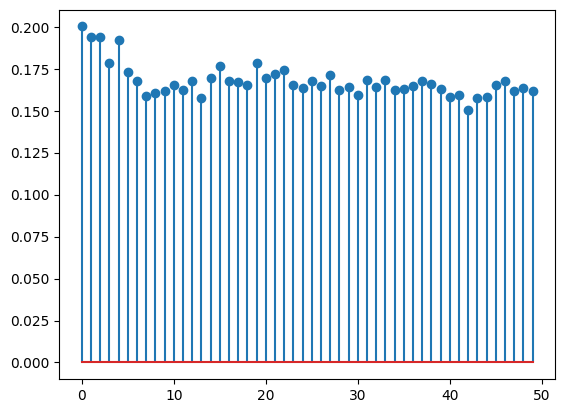

In [ ]:
skip = 0
n = 10
rmse = [metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in+i*n:cfg.seq_len_n_in+(i+1)*n, 0], batch_y_mean[:,i*n:(i+1)*n,0], time_axis=1).mean() for i in range(int(500/n))]
plt.stem(rmse)

In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_binary_on_CSTR_binaryinput: {rmse.mean()}')

iterations: 1000000
train_time: 1.028960087241398 days
WH_binary_on_CSTR_binaryinput: 0.19006693363189697


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_binary_on_binary_signal: {rmse.mean()}')

iterations: 1000000
train_time: 1.6794429362289331 days
WH_binary_on_binary_signal: 0.3093949556350708


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_binary_on_white_noise: {rmse.mean()}')

iterations: 1000000
train_time: 1.6794429362289331 days
WH_binary_on_white_noise: 0.12866806983947754


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_finetuned_with_binary_signal: {rmse.mean()}')

iterations: 100000
train_time: 0.09232402762053189 days
WH_finetuned_with_binary_signal: 0.10579168796539307


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_finetuned_nonosy: {rmse.mean()}')

iterations: 100000
train_time: 0.10222292826407486 days
WH_finetuned_nonosy: 0.05836193636059761


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_on_CSTR_noiseinput: {rmse.mean()}')

iterations: 1000000
train_time: 0.5607672266027441 days
WH_on_CSTR_noiseinput: 0.18109381198883057


In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'WH_on_CSTR_binaryinput: {rmse.mean()}')

In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_RNN_4030_30in: {rmse.mean()}')

In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_normal_4400_last400: {rmse.mean()}')

In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_normal_400ctx: {rmse.mean()}')

In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_400ctx_NORNN_400skip_10in: {rmse.mean()}')

max_iterations: 1000000
n_iterations: 992000
train_time: 1.0623307974498581 days
rmse_400ctx_NORNN_400skip_10in: 0.15032674372196198


In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_800ctx_400skip_10in: {rmse.mean()}')

max_iterations: 1000000
n_iterations: 984000
train_time: 1.0381489119154435 days
rmse_800ctx_400skip_10in: 0.14270329475402832


In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_16000ctx_400skip_30in: {rmse.mean()}')

max_iterations: 1000000
n_iterations: 990000
train_time: 1.6794429362289331 days
rmse_16000ctx_400skip_30in: 0.12866806983947754


In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_8000ctx_64patched_400skip_30in: {rmse.mean()}')

In [ ]:
print(f'max_iterations: {exp_data["cfg"].max_iters}')
print(f'n_iterations: {exp_data["iter_num"]}')
print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'rmse_30000ctx_400skip_30in: {rmse.mean()}')

* no noise: 0.11202768236398697 rmse
* 0.1 noise: 0.17279744148254395 rmse
* 0.2 noise: 0.2482662796974182 rmse
* 0.3 noise: 0.36339396238327026 rmse
* 0.4 noise: 0.5337750911712646 rmse
* 0.5 noise: 0.703009843826294

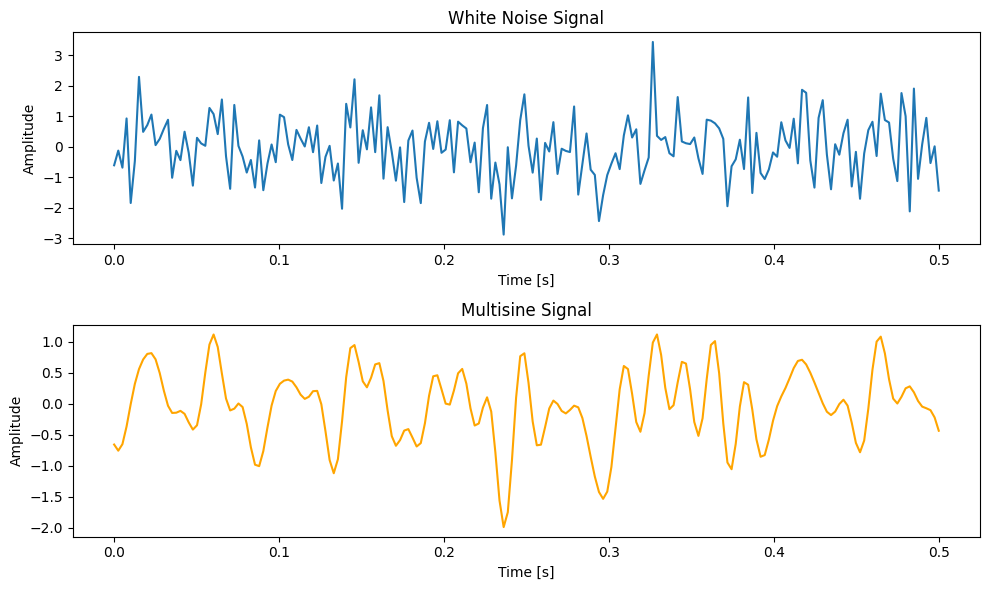

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000      # Sampling frequency (Hz)
T = 1.0        # Duration (seconds)
N = 200  # Total number of samples
frequencies = list(np.arange(150))  # Frequencies to retain (Hz)


np.random.seed(40)
# Generate white noise in the time domain
white_noise = np.random.normal(0, 1, N)

# FFT of the white noise to get it in the frequency domain
fft_noise = np.fft.fft(white_noise)
freqs = np.fft.fftfreq(N, 1/fs)

# Create a mask to retain only the desired frequencies
mask = np.zeros_like(fft_noise, dtype=bool)

# Retain both positive and negative frequencies (since FFT output is symmetric)
for f in frequencies:
    mask[np.abs(freqs - f).argmin()] = True  # Retain positive frequency
    mask[np.abs(freqs + f).argmin()] = True  # Retain negative frequency

# Apply the mask to cut unwanted frequencies
fft_multisine = np.zeros_like(fft_noise)
fft_multisine[mask] = fft_noise[mask]

# Inverse FFT to bring it back to the time domain
multisine_signal = np.fft.ifft(fft_multisine).real

# Plot the results
plt.figure(figsize=(10, 6))

# Original white noise signal
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, T/2, N), white_noise, label='White Noise')
plt.title('White Noise Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Multisine signal
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, T/2, N), multisine_signal, label='Multisine Signal', color='orange')
plt.title('Multisine Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


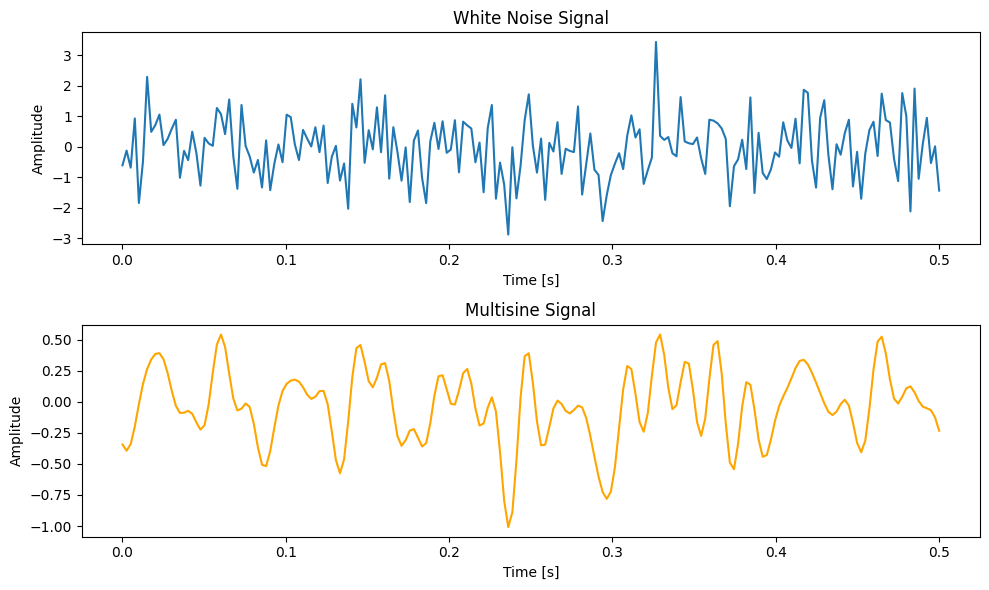

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 2000      # Sampling frequency (Hz)
T = 0.5        # Duration (seconds)
N = 200  # Total number of samples
frequencies = list(np.arange(300))  # Frequencies to retain (Hz)

np.random.seed(40)

# Generate white noise in the time domain
white_noise = np.random.normal(0, 1, N)

# FFT of the white noise to get it in the frequency domain
fft_noise = np.fft.fft(white_noise)
freqs = np.fft.fftfreq(N, 1/fs)

# Create a mask to retain only the desired frequencies
mask = np.zeros_like(fft_noise, dtype=bool)

# Retain both positive and negative frequencies (since FFT output is symmetric)
for f in frequencies:
    # mask[np.abs(freqs - f).argmin()] = True  # Retain positive frequency
    mask[np.abs(freqs + f).argmin()] = True  # Retain negative frequency

# Apply the mask to cut unwanted frequencies
fft_multisine = np.zeros_like(fft_noise)
fft_multisine[mask] = fft_noise[mask]

# Inverse FFT to bring it back to the time domain
multisine_signal = np.fft.ifft(fft_multisine).real

# Plot the results
plt.figure(figsize=(10, 6))

# Original white noise signal
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, T, N), white_noise, label='White Noise')
plt.title('White Noise Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Multisine signal
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, T, N), multisine_signal, label='Multisine Signal', color='orange')
plt.title('Multisine Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
